In [1]:
# !pip install mxnet
# !pip install gluonnlp pandas tqdm
# !pip install sentencepiece
# !pip install transformers==3
# !pip install torch
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, notebook

from torch.nn import init

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
# from transformers import AdamW
# kobert updated from using transformer 3.XX to using transformer 4.xx, optimizer import from torch,
from torch.optim import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit,StratifiedKFold
import random
import gc
import unicodedata

gc.collect()

0

In [2]:
############################################################################
############################################################################
############################################################################

##GPU 사용 시
# there are totally five GPU in server,we can routed to 0:4.
# device = torch.device("cuda:4")
gc.collect()

bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /home/dawn/IPC/For Journal Paper/.cache/kobert_v1.zip
using cached model. /home/dawn/IPC/For Journal Paper/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /home/dawn/IPC/For Journal Paper/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [3]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx,label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        
        self.sentences = []
        self.labels = []
#         for i in dataset:
#             self.sentences.append(transform([i[sent_idx]]))
#             self.labels.append(i[label_idx])
        for i in dataset:
            if len(i[sent_idx])<=max_len:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(i[label_idx])
            else:
                self.sentences.append(transform([i[sent_idx][:max_len]]))
                self.labels.append(i[label_idx])
        

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))
    
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=11,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [5]:
# define parameter
max_len = 512
batch_size = 6
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 20
learning_rate =  5e-6  #5e-5  2e-5
num_workers = 2
n_splits = 5
model_name = 'kobertbest_512.pt'

device = torch.device("cuda:4")

model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
# torch.save(model, 'kobert.pt')

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
torch.save({'modelA':model.state_dict(),'optimizerA':optimizer.state_dict()},'kobert.pt')

loss_fn = nn.CrossEntropyLoss()

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##################################################################################################
# train test validate split

# df_raw = pd.read_csv("extract100datasetmanual.csv?dl=1")
# df_raw = pd.read_csv("dataset200_12manually.csv")

#df_raw = pd.read_csv("12classesdatsetnew.csv",index_col=False )
df_raw = pd.read_csv("class11to134.csv",index_col=False )
# df_raw = pd.read_excel('11classesdatsetnew_20220208.xlsx', engine='openpyxl', sheet_name="classesdatsetnew", header=0)

# df_raw = pd.read_csv("dataset200_13manually2.csv")
# print(df_raw)
# categorylist = ["화장품","핫플레이스","요리음식","여행아웃도어","인테리어","엔터테인먼트"]

categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
# temp_label=[]
# for i in df_raw['label']:
#     temp_label.append(categorylist.index(i))
# df_raw['label']=temp_label

train_test_ratio = 0.8
df_train_list =[None]*11
df_test_list = [None]*11

df_file =[None] *11

for i, labeli in enumerate(range(len(categorylist))):
    df_file[i] = df_raw[df_raw['label'] == labeli]

for i, dffilei in enumerate(df_file):
    df_train_list[i],df_test_list[i] = train_test_split(dffilei,train_size = train_test_ratio, random_state = 1)

df_train = pd.concat([trainlist for trainlist in df_train_list],ignore_index=True,sort=False)
df_test = pd.concat([dftest for dftest in df_test_list],ignore_index=True,sort=False)

import re

df_traindata = df_train.reindex(columns=['label', 'caption'])
# df_traindata = df_train.reindex(columns=['label', 'hashtag'])
# print(df_traindata)
df_trainlabel = df_train.reindex(columns=['label'])
np_data = df_traindata.to_numpy()
np_label = df_trainlabel.to_numpy()

for i in range(len(np_data)):
    np_data[i][1] = unicodedata.normalize('NFC',np_data[i][1])
    np_data[i][1] = ' '.join(re.compile('[가-힣]+').findall(np_data[i][1]))

df_testdata = df_test.reindex(columns=['label', 'caption'])
# df_testdata = df_test.reindex(columns=['label', 'hashtag'])
df_testlabel = df_test.reindex(columns=['label'])
np_testdata = df_testdata.to_numpy()
np_testlabel = df_testlabel.to_numpy()

for i in range(len(np_testdata)):
    np_testdata[i][1] = unicodedata.normalize('NFC',np_testdata[i][1])
    np_testdata[i][1] = ' '.join(re.compile('[가-힣]+').findall(np_testdata[i][1]))

print(np_testdata)


[[0
  '듬뿍 담긴 허브의 힘 오프레시샴푸 지성두피 건성모발 탈모증상 등 모발 고민을 가득 담긴 허브의 힘으로 깨끗하게 씻어내자 헤어플러스 오프레시샴푸 모발관리 헤어케어 샴푸 탈모샴푸 지성두피 두피각질 헤어제품 에센스추천 머릿결 머릿결관리 극손상모 트리트먼트 헤어스타그램 모발보호 단백질 여자머리스타일 여자머리']
 [0
  'x 9 x 83 유튜브 첫 메이크업 영상 첫 영상을 올리고 나서 몇 개월이라는 많은 시간이 지났어요 그동안 영상도 많이 찍어봤지만 조금 더 완성도 있는 영상으로 찾아뵙고 싶어서 이렇게 오랜 시간이 걸리게 됐습니다 제 첫 메이크업 영상은 여름쿨톤 을 위한 튜토리얼 인데요 여쿨 중에서도 여름뮤트 메이크업을 해봤어요 아직 부족한 부분이 많은 영상이지만 제가 퍼스널컬러와 셀프 뷰티꿀팁에 관심이 많은 만큼 더 퀄리티 높은 다양한 컨텐츠로 찾아뵙겠습니다 영상은 인스타 프로필 링크로 넘어오셔서 바로 보이는 메이크업 튜토리얼 영상 누르시면 확인하실 수 있습니다 설라 seol la 구독과 좋아요 그리고 댓글도 부탁드리겠습니다 많은 관심과 사랑 부탁드려요오 뷰티유튜브 뷰티유튜버 여쿨뮤트 여쿨메이크업 여쿨립 여름메이크업 뮤트 뮤트톤']
 [0
  '탈모에 도움을 준다고 하는 트리플에스샴푸 일단 엄청나게 큰 대용량에 깜짝 놀라고 샴푸 후에 두피가 개운해지는 느낌에 한 번 더 놀라게되는 샴푸에요 자극적이지 않으면서도 시원하고 화하게 두피 열을 내려줘서 탈모에도 도움이 되는 걸까요 거품도 조밀하고 마음에 들어요 트리플에스샴푸 탈모샴푸 탈모 탈모방지샴푸 샴푸 두피 모발 지루성두피염 지루성피부염 두피관리 모발관리 원형탈모 출산후탈모 자형탈모 스트레스성탈모 유전적탈모 shampoo hair haircare hairstyle']
 [0
  '토너 세럼 미스트를 한번에 올인원 달바화이트트러플미스트세럼 은 화이트트러플 과 아보카토오일 이 피부에 광채와 생기를 선사하여 화장 전이나 피부가 건조할 때 수시로 뿌려주고 있다는 메이크업 할 때도 뿌려주면 생기있어 보여 좋다 승무

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/157 Cost: 2.428628 Train Acc 0.16666666666666666
Epoch 1/20 Batch 21/157 Cost: 2.568740 Train Acc 0.10317460317460317
Epoch 1/20 Batch 41/157 Cost: 2.428315 Train Acc 0.10975609756097558
Epoch 1/20 Batch 61/157 Cost: 2.232521 Train Acc 0.09836065573770492
Epoch 1/20 Batch 81/157 Cost: 2.569120 Train Acc 0.1049382716049383
Epoch 1/20 Batch 101/157 Cost: 2.145262 Train Acc 0.10066006600660066
Epoch 1/20 Batch 121/157 Cost: 2.590369 Train Acc 0.10192837465564734
Epoch 1/20 Batch 141/157 Cost: 2.571159 Train Acc 0.0981087470449172

Epoch 1/20 Cost: 2.186156 Train Acc 0.09915074309978764


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.186156 Test Acc 0.15416666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/157 Cost: 2.483630 Train Acc 0.0
Epoch 2/20 Batch 21/157 Cost: 2.353362 Train Acc 0.0873015873015873
Epoch 2/20 Batch 41/157 Cost: 2.472405 Train Acc 0.07723577235772357
Epoch 2/20 Batch 61/157 Cost: 2.405312 Train Acc 0.08469945355191258
Epoch 2/20 Batch 81/157 Cost: 2.458322 Train Acc 0.10082304526748972
Epoch 2/20 Batch 101/157 Cost: 2.126773 Train Acc 0.11386138613861387
Epoch 2/20 Batch 121/157 Cost: 2.495721 Train Acc 0.11983471074380164
Epoch 2/20 Batch 141/157 Cost: 2.339938 Train Acc 0.11820330969267137

Epoch 2/20 Cost: 2.322092 Train Acc 0.1276008492569002


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.322092 Test Acc 0.4458333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/157 Cost: 2.343434 Train Acc 0.3333333333333333
Epoch 3/20 Batch 21/157 Cost: 2.115274 Train Acc 0.34920634920634913
Epoch 3/20 Batch 41/157 Cost: 2.145938 Train Acc 0.35772357723577236
Epoch 3/20 Batch 61/157 Cost: 2.080010 Train Acc 0.366120218579235
Epoch 3/20 Batch 81/157 Cost: 2.125708 Train Acc 0.4032921810699589
Epoch 3/20 Batch 101/157 Cost: 2.193309 Train Acc 0.4620462046204621
Epoch 3/20 Batch 121/157 Cost: 1.920246 Train Acc 0.5123966942148761
Epoch 3/20 Batch 141/157 Cost: 1.784571 Train Acc 0.5437352245862884

Epoch 3/20 Cost: 1.612908 Train Acc 0.5772823779193205


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.612908 Test Acc 0.9125


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/157 Cost: 1.520089 Train Acc 1.0
Epoch 4/20 Batch 21/157 Cost: 1.929044 Train Acc 0.8333333333333334
Epoch 4/20 Batch 41/157 Cost: 1.567172 Train Acc 0.8373983739837397
Epoch 4/20 Batch 61/157 Cost: 1.910830 Train Acc 0.8524590163934428
Epoch 4/20 Batch 81/157 Cost: 1.585673 Train Acc 0.8641975308641975
Epoch 4/20 Batch 101/157 Cost: 1.313843 Train Acc 0.8762376237623758
Epoch 4/20 Batch 121/157 Cost: 1.139130 Train Acc 0.8829201101928367
Epoch 4/20 Batch 141/157 Cost: 0.963154 Train Acc 0.8912529550827416

Epoch 4/20 Cost: 0.924857 Train Acc 0.898089171974522


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.924857 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/157 Cost: 1.085703 Train Acc 0.8333333333333334
Epoch 5/20 Batch 21/157 Cost: 1.303387 Train Acc 0.9365079365079365
Epoch 5/20 Batch 41/157 Cost: 0.860588 Train Acc 0.9512195121951219
Epoch 5/20 Batch 61/157 Cost: 0.868064 Train Acc 0.9508196721311477
Epoch 5/20 Batch 81/157 Cost: 0.884522 Train Acc 0.9567901234567903
Epoch 5/20 Batch 101/157 Cost: 0.903421 Train Acc 0.9554455445544553
Epoch 5/20 Batch 121/157 Cost: 0.610794 Train Acc 0.958677685950413
Epoch 5/20 Batch 141/157 Cost: 0.591316 Train Acc 0.960992907801418

Epoch 5/20 Cost: 0.770052 Train Acc 0.9607218683651801


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.770052 Test Acc 0.958333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/157 Cost: 0.930811 Train Acc 0.8333333333333334
Epoch 6/20 Batch 21/157 Cost: 0.650497 Train Acc 0.9920634920634922
Epoch 6/20 Batch 41/157 Cost: 0.599868 Train Acc 0.9878048780487807
Epoch 6/20 Batch 61/157 Cost: 0.600335 Train Acc 0.980874316939891
Epoch 6/20 Batch 81/157 Cost: 1.001103 Train Acc 0.9753086419753089
Epoch 6/20 Batch 101/157 Cost: 0.477461 Train Acc 0.9735973597359738
Epoch 6/20 Batch 121/157 Cost: 0.460928 Train Acc 0.9765840220385676
Epoch 6/20 Batch 141/157 Cost: 0.366129 Train Acc 0.9775413711583927

Epoch 6/20 Cost: 0.476247 Train Acc 0.9787685774946925


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.476247 Test Acc 0.9625


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/157 Cost: 0.439414 Train Acc 1.0
Epoch 7/20 Batch 21/157 Cost: 0.395842 Train Acc 1.0
Epoch 7/20 Batch 41/157 Cost: 0.312292 Train Acc 1.0
Epoch 7/20 Batch 61/157 Cost: 0.856633 Train Acc 0.9945355191256832
Epoch 7/20 Batch 81/157 Cost: 0.335273 Train Acc 0.9938271604938271
Epoch 7/20 Batch 101/157 Cost: 0.362720 Train Acc 0.9933993399339933
Epoch 7/20 Batch 121/157 Cost: 0.499715 Train Acc 0.9903581267217629
Epoch 7/20 Batch 141/157 Cost: 0.865870 Train Acc 0.9869976359338061

Epoch 7/20 Cost: 0.292465 Train Acc 0.9872611464968153


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.292465 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/157 Cost: 0.277566 Train Acc 1.0
Epoch 8/20 Batch 21/157 Cost: 0.255231 Train Acc 1.0
Epoch 8/20 Batch 41/157 Cost: 0.280048 Train Acc 1.0
Epoch 8/20 Batch 61/157 Cost: 0.215279 Train Acc 0.9945355191256832
Epoch 8/20 Batch 81/157 Cost: 0.199436 Train Acc 0.9938271604938271
Epoch 8/20 Batch 101/157 Cost: 0.216568 Train Acc 0.9933993399339933
Epoch 8/20 Batch 121/157 Cost: 0.287664 Train Acc 0.9944903581267217
Epoch 8/20 Batch 141/157 Cost: 0.204377 Train Acc 0.995271867612293

Epoch 8/20 Cost: 0.150398 Train Acc 0.9936305732484076


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.150398 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/157 Cost: 0.165920 Train Acc 1.0
Epoch 9/20 Batch 21/157 Cost: 0.190768 Train Acc 0.992063492063492
Epoch 9/20 Batch 41/157 Cost: 0.212574 Train Acc 0.9959349593495934
Epoch 9/20 Batch 61/157 Cost: 0.169801 Train Acc 0.9972677595628414
Epoch 9/20 Batch 81/157 Cost: 0.176126 Train Acc 0.9979423868312757
Epoch 9/20 Batch 101/157 Cost: 0.147920 Train Acc 0.9983498349834983
Epoch 9/20 Batch 121/157 Cost: 0.122676 Train Acc 0.9986225895316804
Epoch 9/20 Batch 141/157 Cost: 0.177662 Train Acc 0.9988179669030731

Epoch 9/20 Cost: 0.107144 Train Acc 0.9957537154989385


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.107144 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/157 Cost: 0.147015 Train Acc 1.0
Epoch 10/20 Batch 21/157 Cost: 0.443000 Train Acc 0.9841269841269842
Epoch 10/20 Batch 41/157 Cost: 0.140943 Train Acc 0.9918699186991871
Epoch 10/20 Batch 61/157 Cost: 0.108337 Train Acc 0.9945355191256832
Epoch 10/20 Batch 81/157 Cost: 0.122147 Train Acc 0.9938271604938271
Epoch 10/20 Batch 101/157 Cost: 0.107502 Train Acc 0.9933993399339933
Epoch 10/20 Batch 121/157 Cost: 0.077870 Train Acc 0.9931129476584021
Epoch 10/20 Batch 141/157 Cost: 0.116482 Train Acc 0.9940898345153664

Epoch 10/20 Cost: 0.120930 Train Acc 0.9936305732484076


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.120930 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/157 Cost: 0.106184 Train Acc 1.0
Epoch 11/20 Batch 21/157 Cost: 0.094448 Train Acc 1.0
Epoch 11/20 Batch 41/157 Cost: 0.112554 Train Acc 0.991869918699187
Epoch 11/20 Batch 61/157 Cost: 0.101721 Train Acc 0.994535519125683
Epoch 11/20 Batch 81/157 Cost: 0.096273 Train Acc 0.9958847736625513
Epoch 11/20 Batch 101/157 Cost: 0.092330 Train Acc 0.9966996699669967
Epoch 11/20 Batch 121/157 Cost: 0.091628 Train Acc 0.9972451790633609
Epoch 11/20 Batch 141/157 Cost: 0.081301 Train Acc 0.9964539007092199

Epoch 11/20 Cost: 0.088061 Train Acc 0.9968152866242038


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.088061 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/157 Cost: 0.071946 Train Acc 1.0
Epoch 12/20 Batch 21/157 Cost: 0.074686 Train Acc 1.0
Epoch 12/20 Batch 41/157 Cost: 0.083029 Train Acc 0.9959349593495934
Epoch 12/20 Batch 61/157 Cost: 0.082847 Train Acc 0.9972677595628414
Epoch 12/20 Batch 81/157 Cost: 0.061554 Train Acc 0.9979423868312757
Epoch 12/20 Batch 101/157 Cost: 0.071708 Train Acc 0.9983498349834983
Epoch 12/20 Batch 121/157 Cost: 0.073489 Train Acc 0.9986225895316804
Epoch 12/20 Batch 141/157 Cost: 0.062732 Train Acc 0.9988179669030731

Epoch 12/20 Cost: 0.068026 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.068026 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/157 Cost: 0.070811 Train Acc 1.0
Epoch 13/20 Batch 21/157 Cost: 0.075197 Train Acc 1.0
Epoch 13/20 Batch 41/157 Cost: 0.060713 Train Acc 1.0
Epoch 13/20 Batch 61/157 Cost: 0.066695 Train Acc 1.0
Epoch 13/20 Batch 81/157 Cost: 0.078164 Train Acc 1.0
Epoch 13/20 Batch 101/157 Cost: 0.062367 Train Acc 1.0
Epoch 13/20 Batch 121/157 Cost: 0.066244 Train Acc 1.0
Epoch 13/20 Batch 141/157 Cost: 0.074614 Train Acc 1.0

Epoch 13/20 Cost: 0.065550 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.065550 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/157 Cost: 0.060073 Train Acc 1.0
Epoch 14/20 Batch 21/157 Cost: 0.072587 Train Acc 1.0
Epoch 14/20 Batch 41/157 Cost: 0.062790 Train Acc 1.0
Epoch 14/20 Batch 61/157 Cost: 0.051052 Train Acc 0.9972677595628415
Epoch 14/20 Batch 81/157 Cost: 0.064967 Train Acc 0.9979423868312758
Epoch 14/20 Batch 101/157 Cost: 0.072223 Train Acc 0.9983498349834985
Epoch 14/20 Batch 121/157 Cost: 0.039676 Train Acc 0.9986225895316805
Epoch 14/20 Batch 141/157 Cost: 0.061969 Train Acc 0.9988179669030733

Epoch 14/20 Cost: 0.043882 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.043882 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/157 Cost: 0.061530 Train Acc 1.0
Epoch 15/20 Batch 21/157 Cost: 0.058930 Train Acc 1.0
Epoch 15/20 Batch 41/157 Cost: 0.069270 Train Acc 1.0
Epoch 15/20 Batch 61/157 Cost: 0.059183 Train Acc 1.0
Epoch 15/20 Batch 81/157 Cost: 0.068264 Train Acc 1.0
Epoch 15/20 Batch 101/157 Cost: 0.040585 Train Acc 1.0
Epoch 15/20 Batch 121/157 Cost: 0.052042 Train Acc 1.0
Epoch 15/20 Batch 141/157 Cost: 0.062598 Train Acc 1.0

Epoch 15/20 Cost: 0.047034 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.047034 Test Acc 0.966666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/157 Cost: 0.047840 Train Acc 1.0
Epoch 16/20 Batch 21/157 Cost: 0.058108 Train Acc 1.0
Epoch 16/20 Batch 41/157 Cost: 0.045498 Train Acc 1.0
Epoch 16/20 Batch 61/157 Cost: 0.042135 Train Acc 1.0
Epoch 16/20 Batch 81/157 Cost: 0.052269 Train Acc 1.0
Epoch 16/20 Batch 101/157 Cost: 0.049041 Train Acc 0.9983498349834983
Epoch 16/20 Batch 121/157 Cost: 0.048382 Train Acc 0.9986225895316804
Epoch 16/20 Batch 141/157 Cost: 0.062501 Train Acc 0.9988179669030731

Epoch 16/20 Cost: 0.049805 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.049805 Test Acc 0.9666666666666668


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/157 Cost: 0.051216 Train Acc 1.0
Epoch 17/20 Batch 21/157 Cost: 0.054219 Train Acc 1.0
Epoch 17/20 Batch 41/157 Cost: 0.047374 Train Acc 1.0
Epoch 17/20 Batch 61/157 Cost: 0.044609 Train Acc 1.0
Epoch 17/20 Batch 81/157 Cost: 0.056942 Train Acc 1.0
Epoch 17/20 Batch 101/157 Cost: 0.052643 Train Acc 1.0
Epoch 17/20 Batch 121/157 Cost: 0.054255 Train Acc 0.9986225895316804
Epoch 17/20 Batch 141/157 Cost: 0.055028 Train Acc 0.9988179669030731

Epoch 17/20 Cost: 0.061962 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.061962 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/157 Cost: 0.044824 Train Acc 1.0
Epoch 18/20 Batch 21/157 Cost: 0.052955 Train Acc 1.0
Epoch 18/20 Batch 41/157 Cost: 0.045244 Train Acc 1.0
Epoch 18/20 Batch 61/157 Cost: 0.061915 Train Acc 1.0
Epoch 18/20 Batch 81/157 Cost: 0.055816 Train Acc 1.0
Epoch 18/20 Batch 101/157 Cost: 0.058750 Train Acc 1.0
Epoch 18/20 Batch 121/157 Cost: 0.050507 Train Acc 1.0
Epoch 18/20 Batch 141/157 Cost: 0.044857 Train Acc 1.0

Epoch 18/20 Cost: 0.046275 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.046275 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/157 Cost: 0.045104 Train Acc 1.0
Epoch 19/20 Batch 21/157 Cost: 0.043723 Train Acc 1.0
Epoch 19/20 Batch 41/157 Cost: 0.041231 Train Acc 1.0
Epoch 19/20 Batch 61/157 Cost: 0.058267 Train Acc 1.0
Epoch 19/20 Batch 81/157 Cost: 0.055651 Train Acc 1.0
Epoch 19/20 Batch 101/157 Cost: 0.039144 Train Acc 0.9983498349834983
Epoch 19/20 Batch 121/157 Cost: 0.048910 Train Acc 0.9986225895316804
Epoch 19/20 Batch 141/157 Cost: 0.049078 Train Acc 0.9988179669030731

Epoch 19/20 Cost: 0.053645 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.053645 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/157 Cost: 0.054524 Train Acc 1.0
Epoch 20/20 Batch 21/157 Cost: 0.044474 Train Acc 1.0
Epoch 20/20 Batch 41/157 Cost: 0.061338 Train Acc 1.0
Epoch 20/20 Batch 61/157 Cost: 0.050311 Train Acc 1.0
Epoch 20/20 Batch 81/157 Cost: 0.046758 Train Acc 1.0
Epoch 20/20 Batch 101/157 Cost: 0.057405 Train Acc 1.0
Epoch 20/20 Batch 121/157 Cost: 0.049091 Train Acc 1.0
Epoch 20/20 Batch 141/157 Cost: 0.049175 Train Acc 0.9988179669030731

Epoch 20/20 Cost: 0.049136 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.049136 Test Acc 0.9666666666666666
[0.09915074309978764, 0.1276008492569002, 0.5772823779193205, 0.898089171974522, 0.9607218683651801, 0.9787685774946925, 0.9872611464968153, 0.9936305732484076, 0.9957537154989385, 0.9936305732484076, 0.9968152866242038, 0.9989384288747345, 0.9989384288747347, 0.9989384288747347, 1.0, 0.9989384288747345, 0.9989384288747345, 0.9989384288747347, 0.9989384288747345, 0.9989384288747345]
[0.15416666666666667, 0.4458333333333333, 0.9125, 0.95, 0.958333333333333, 0.9625, 0.9666666666666666, 0.9666666666666666, 0.9666666666666666, 0.9666666666666666, 0.9666666666666666, 0.9666666666666666, 0.9541666666666666, 0.9666666666666666, 0.966666666666667, 0.9666666666666668, 0.9666666666666666, 0.9666666666666666, 0.9666666666666666, 0.9666666666666666]


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/157 Cost: 2.681926 Train Acc 0.0
Epoch 1/20 Batch 21/157 Cost: 2.280486 Train Acc 0.15079365079365076
Epoch 1/20 Batch 41/157 Cost: 2.407503 Train Acc 0.13414634146341464
Epoch 1/20 Batch 61/157 Cost: 2.457416 Train Acc 0.11475409836065578
Epoch 1/20 Batch 81/157 Cost: 2.423979 Train Acc 0.11728395061728394
Epoch 1/20 Batch 101/157 Cost: 2.535829 Train Acc 0.11551155115511547
Epoch 1/20 Batch 121/157 Cost: 2.597676 Train Acc 0.11019283746556467
Epoch 1/20 Batch 141/157 Cost: 2.275712 Train Acc 0.11465721040189115

Epoch 1/20 Cost: 2.521842 Train Acc 0.11040339702760082


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.521842 Test Acc 0.11249999999999998


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/157 Cost: 2.275988 Train Acc 0.16666666666666666
Epoch 2/20 Batch 21/157 Cost: 2.217079 Train Acc 0.14285714285714285
Epoch 2/20 Batch 41/157 Cost: 2.592649 Train Acc 0.13821138211382114
Epoch 2/20 Batch 61/157 Cost: 2.248694 Train Acc 0.10928961748633881
Epoch 2/20 Batch 81/157 Cost: 2.377763 Train Acc 0.1172839506172839
Epoch 2/20 Batch 101/157 Cost: 2.339707 Train Acc 0.1303630363036303
Epoch 2/20 Batch 121/157 Cost: 2.286806 Train Acc 0.1363636363636363
Epoch 2/20 Batch 141/157 Cost: 2.457368 Train Acc 0.14775413711583926

Epoch 2/20 Cost: 2.152587 Train Acc 0.15774946921443742


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.152587 Test Acc 0.4374999999999999


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/157 Cost: 2.170297 Train Acc 0.5
Epoch 3/20 Batch 21/157 Cost: 2.332551 Train Acc 0.2777777777777778
Epoch 3/20 Batch 41/157 Cost: 1.934115 Train Acc 0.34146341463414637
Epoch 3/20 Batch 61/157 Cost: 2.072676 Train Acc 0.4098360655737705
Epoch 3/20 Batch 81/157 Cost: 2.107733 Train Acc 0.4691358024691357
Epoch 3/20 Batch 101/157 Cost: 1.934473 Train Acc 0.5297029702970297
Epoch 3/20 Batch 121/157 Cost: 2.089086 Train Acc 0.5757575757575757
Epoch 3/20 Batch 141/157 Cost: 1.468526 Train Acc 0.6016548463356973

Epoch 3/20 Cost: 1.491977 Train Acc 0.6284501061571124


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.491977 Test Acc 0.9


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/157 Cost: 1.526168 Train Acc 0.8333333333333334
Epoch 4/20 Batch 21/157 Cost: 1.467701 Train Acc 0.9126984126984126
Epoch 4/20 Batch 41/157 Cost: 1.488341 Train Acc 0.9105691056910568
Epoch 4/20 Batch 61/157 Cost: 1.200434 Train Acc 0.9153005464480874
Epoch 4/20 Batch 81/157 Cost: 1.253319 Train Acc 0.9156378600823046
Epoch 4/20 Batch 101/157 Cost: 1.188858 Train Acc 0.9207920792079206
Epoch 4/20 Batch 121/157 Cost: 1.409718 Train Acc 0.9187327823691457
Epoch 4/20 Batch 141/157 Cost: 0.925689 Train Acc 0.9219858156028364

Epoch 4/20 Cost: 0.984495 Train Acc 0.9214437367303605


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.984495 Test Acc 0.9333333333333332


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/157 Cost: 0.879515 Train Acc 1.0
Epoch 5/20 Batch 21/157 Cost: 0.842782 Train Acc 0.9682539682539684
Epoch 5/20 Batch 41/157 Cost: 1.069738 Train Acc 0.9674796747967479
Epoch 5/20 Batch 61/157 Cost: 1.043688 Train Acc 0.9617486338797816
Epoch 5/20 Batch 81/157 Cost: 0.714696 Train Acc 0.9711934156378603
Epoch 5/20 Batch 101/157 Cost: 0.746544 Train Acc 0.9735973597359737
Epoch 5/20 Batch 121/157 Cost: 0.687975 Train Acc 0.9710743801652891
Epoch 5/20 Batch 141/157 Cost: 0.670709 Train Acc 0.968085106382979

Epoch 5/20 Cost: 0.706544 Train Acc 0.9690021231422509


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.706544 Test Acc 0.9416666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/157 Cost: 0.856229 Train Acc 0.8333333333333334
Epoch 6/20 Batch 21/157 Cost: 0.595224 Train Acc 0.9841269841269842
Epoch 6/20 Batch 41/157 Cost: 0.787049 Train Acc 0.9878048780487807
Epoch 6/20 Batch 61/157 Cost: 0.574194 Train Acc 0.9754098360655741
Epoch 6/20 Batch 81/157 Cost: 0.819527 Train Acc 0.9732510288065844
Epoch 6/20 Batch 101/157 Cost: 0.563548 Train Acc 0.976897689768977
Epoch 6/20 Batch 121/157 Cost: 0.459131 Train Acc 0.9807162534435262
Epoch 6/20 Batch 141/157 Cost: 0.449358 Train Acc 0.9822695035460993

Epoch 6/20 Cost: 0.444839 Train Acc 0.9840764331210191


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.444839 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/157 Cost: 0.398044 Train Acc 1.0
Epoch 7/20 Batch 21/157 Cost: 0.383043 Train Acc 0.992063492063492
Epoch 7/20 Batch 41/157 Cost: 0.371348 Train Acc 0.9959349593495934
Epoch 7/20 Batch 61/157 Cost: 0.377676 Train Acc 0.9972677595628414
Epoch 7/20 Batch 81/157 Cost: 0.333773 Train Acc 0.9958847736625513
Epoch 7/20 Batch 101/157 Cost: 0.410967 Train Acc 0.9933993399339932
Epoch 7/20 Batch 121/157 Cost: 0.402095 Train Acc 0.993112947658402
Epoch 7/20 Batch 141/157 Cost: 0.277393 Train Acc 0.9940898345153661

Epoch 7/20 Cost: 0.231009 Train Acc 0.9946921443736728


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.231009 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/157 Cost: 0.282988 Train Acc 1.0
Epoch 8/20 Batch 21/157 Cost: 0.254212 Train Acc 1.0
Epoch 8/20 Batch 41/157 Cost: 0.248073 Train Acc 0.9959349593495934
Epoch 8/20 Batch 61/157 Cost: 0.194116 Train Acc 0.9972677595628414
Epoch 8/20 Batch 81/157 Cost: 0.233001 Train Acc 0.9958847736625513
Epoch 8/20 Batch 101/157 Cost: 0.216891 Train Acc 0.9950495049504949
Epoch 8/20 Batch 121/157 Cost: 0.289411 Train Acc 0.993112947658402
Epoch 8/20 Batch 141/157 Cost: 0.189583 Train Acc 0.9929078014184395

Epoch 8/20 Cost: 0.187262 Train Acc 0.9925690021231421


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.187262 Test Acc 0.9583333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/157 Cost: 0.222449 Train Acc 1.0
Epoch 9/20 Batch 21/157 Cost: 0.185327 Train Acc 0.992063492063492
Epoch 9/20 Batch 41/157 Cost: 0.181484 Train Acc 0.9959349593495934
Epoch 9/20 Batch 61/157 Cost: 0.177483 Train Acc 0.9972677595628414
Epoch 9/20 Batch 81/157 Cost: 0.160677 Train Acc 0.9958847736625513
Epoch 9/20 Batch 101/157 Cost: 0.170218 Train Acc 0.9966996699669967
Epoch 9/20 Batch 121/157 Cost: 0.177821 Train Acc 0.9972451790633609
Epoch 9/20 Batch 141/157 Cost: 0.122211 Train Acc 0.9964539007092199

Epoch 9/20 Cost: 0.149185 Train Acc 0.9968152866242038


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.149185 Test Acc 0.9625


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/157 Cost: 0.151660 Train Acc 1.0
Epoch 10/20 Batch 21/157 Cost: 0.104791 Train Acc 1.0
Epoch 10/20 Batch 41/157 Cost: 0.141365 Train Acc 0.991869918699187
Epoch 10/20 Batch 61/157 Cost: 0.137606 Train Acc 0.994535519125683
Epoch 10/20 Batch 81/157 Cost: 0.133909 Train Acc 0.9958847736625513
Epoch 10/20 Batch 101/157 Cost: 0.129261 Train Acc 0.9966996699669967
Epoch 10/20 Batch 121/157 Cost: 0.136998 Train Acc 0.9972451790633609
Epoch 10/20 Batch 141/157 Cost: 0.109739 Train Acc 0.9976359338061465

Epoch 10/20 Cost: 0.104492 Train Acc 0.9968152866242038


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.104492 Test Acc 0.9583333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/157 Cost: 0.077846 Train Acc 1.0
Epoch 11/20 Batch 21/157 Cost: 0.099759 Train Acc 1.0
Epoch 11/20 Batch 41/157 Cost: 0.089955 Train Acc 0.9959349593495935
Epoch 11/20 Batch 61/157 Cost: 0.093451 Train Acc 0.9972677595628415
Epoch 11/20 Batch 81/157 Cost: 0.097671 Train Acc 0.9979423868312758
Epoch 11/20 Batch 101/157 Cost: 0.110187 Train Acc 0.9983498349834985
Epoch 11/20 Batch 121/157 Cost: 0.084796 Train Acc 0.9986225895316805
Epoch 11/20 Batch 141/157 Cost: 0.087784 Train Acc 0.9976359338061467

Epoch 11/20 Cost: 0.082958 Train Acc 0.9978768577494693


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.082958 Test Acc 0.9708333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/157 Cost: 0.099938 Train Acc 1.0
Epoch 12/20 Batch 21/157 Cost: 0.093484 Train Acc 1.0
Epoch 12/20 Batch 41/157 Cost: 0.073361 Train Acc 1.0
Epoch 12/20 Batch 61/157 Cost: 0.392504 Train Acc 0.9945355191256832
Epoch 12/20 Batch 81/157 Cost: 0.072474 Train Acc 0.9958847736625515
Epoch 12/20 Batch 101/157 Cost: 0.073844 Train Acc 0.9966996699669968
Epoch 12/20 Batch 121/157 Cost: 0.089787 Train Acc 0.997245179063361
Epoch 12/20 Batch 141/157 Cost: 0.080692 Train Acc 0.9976359338061467

Epoch 12/20 Cost: 0.063337 Train Acc 0.996815286624204


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.063337 Test Acc 0.9708333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/157 Cost: 0.066027 Train Acc 1.0
Epoch 13/20 Batch 21/157 Cost: 0.054515 Train Acc 1.0
Epoch 13/20 Batch 41/157 Cost: 0.079099 Train Acc 1.0
Epoch 13/20 Batch 61/157 Cost: 0.074809 Train Acc 1.0
Epoch 13/20 Batch 81/157 Cost: 0.082717 Train Acc 1.0
Epoch 13/20 Batch 101/157 Cost: 0.059347 Train Acc 0.9983498349834983
Epoch 13/20 Batch 121/157 Cost: 0.062612 Train Acc 0.9972451790633609
Epoch 13/20 Batch 141/157 Cost: 0.068230 Train Acc 0.9976359338061465

Epoch 13/20 Cost: 0.081957 Train Acc 0.9978768577494691


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.081957 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/157 Cost: 0.062982 Train Acc 1.0
Epoch 14/20 Batch 21/157 Cost: 0.064139 Train Acc 1.0
Epoch 14/20 Batch 41/157 Cost: 0.065272 Train Acc 1.0
Epoch 14/20 Batch 61/157 Cost: 0.062095 Train Acc 1.0
Epoch 14/20 Batch 81/157 Cost: 0.058626 Train Acc 1.0
Epoch 14/20 Batch 101/157 Cost: 0.045716 Train Acc 1.0
Epoch 14/20 Batch 121/157 Cost: 0.059552 Train Acc 0.9986225895316804
Epoch 14/20 Batch 141/157 Cost: 0.060598 Train Acc 0.9988179669030731

Epoch 14/20 Cost: 0.049486 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.049486 Test Acc 0.9666666666666668


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/157 Cost: 0.051708 Train Acc 1.0
Epoch 15/20 Batch 21/157 Cost: 0.062241 Train Acc 1.0
Epoch 15/20 Batch 41/157 Cost: 0.073801 Train Acc 1.0
Epoch 15/20 Batch 61/157 Cost: 0.050102 Train Acc 1.0
Epoch 15/20 Batch 81/157 Cost: 0.065834 Train Acc 1.0
Epoch 15/20 Batch 101/157 Cost: 0.055068 Train Acc 1.0
Epoch 15/20 Batch 121/157 Cost: 0.041560 Train Acc 1.0
Epoch 15/20 Batch 141/157 Cost: 0.050924 Train Acc 1.0

Epoch 15/20 Cost: 0.048974 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.048974 Test Acc 0.9666666666666668


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/157 Cost: 0.056791 Train Acc 1.0
Epoch 16/20 Batch 21/157 Cost: 0.042668 Train Acc 1.0
Epoch 16/20 Batch 41/157 Cost: 0.056498 Train Acc 1.0
Epoch 16/20 Batch 61/157 Cost: 0.052065 Train Acc 1.0
Epoch 16/20 Batch 81/157 Cost: 0.043287 Train Acc 1.0
Epoch 16/20 Batch 101/157 Cost: 0.055882 Train Acc 0.9983498349834983
Epoch 16/20 Batch 121/157 Cost: 0.049081 Train Acc 0.9986225895316804
Epoch 16/20 Batch 141/157 Cost: 0.058285 Train Acc 0.9988179669030731

Epoch 16/20 Cost: 0.049143 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.049143 Test Acc 0.9666666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/157 Cost: 0.051285 Train Acc 1.0
Epoch 17/20 Batch 21/157 Cost: 0.053647 Train Acc 1.0
Epoch 17/20 Batch 41/157 Cost: 0.045843 Train Acc 1.0
Epoch 17/20 Batch 61/157 Cost: 0.053227 Train Acc 1.0
Epoch 17/20 Batch 81/157 Cost: 0.056783 Train Acc 1.0
Epoch 17/20 Batch 101/157 Cost: 0.044398 Train Acc 1.0
Epoch 17/20 Batch 121/157 Cost: 0.051247 Train Acc 1.0
Epoch 17/20 Batch 141/157 Cost: 0.055733 Train Acc 1.0

Epoch 17/20 Cost: 0.050362 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.050362 Test Acc 0.9583333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/157 Cost: 0.055490 Train Acc 1.0
Epoch 18/20 Batch 21/157 Cost: 0.048457 Train Acc 1.0
Epoch 18/20 Batch 41/157 Cost: 0.051336 Train Acc 1.0
Epoch 18/20 Batch 61/157 Cost: 0.049654 Train Acc 1.0
Epoch 18/20 Batch 81/157 Cost: 0.049468 Train Acc 1.0
Epoch 18/20 Batch 101/157 Cost: 0.047967 Train Acc 1.0
Epoch 18/20 Batch 121/157 Cost: 0.049112 Train Acc 1.0
Epoch 18/20 Batch 141/157 Cost: 0.060251 Train Acc 0.9988179669030731

Epoch 18/20 Cost: 0.041969 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.041969 Test Acc 0.9583333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/157 Cost: 0.056644 Train Acc 1.0
Epoch 19/20 Batch 21/157 Cost: 0.057349 Train Acc 1.0
Epoch 19/20 Batch 41/157 Cost: 0.059026 Train Acc 1.0
Epoch 19/20 Batch 61/157 Cost: 0.057132 Train Acc 0.9972677595628415
Epoch 19/20 Batch 81/157 Cost: 0.044347 Train Acc 0.9979423868312758
Epoch 19/20 Batch 101/157 Cost: 0.043740 Train Acc 0.9983498349834985
Epoch 19/20 Batch 121/157 Cost: 0.054116 Train Acc 0.9986225895316805
Epoch 19/20 Batch 141/157 Cost: 0.041921 Train Acc 0.9988179669030733

Epoch 19/20 Cost: 0.047602 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.047602 Test Acc 0.9583333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/157 Cost: 0.050173 Train Acc 1.0
Epoch 20/20 Batch 21/157 Cost: 0.045506 Train Acc 1.0
Epoch 20/20 Batch 41/157 Cost: 0.051947 Train Acc 1.0
Epoch 20/20 Batch 61/157 Cost: 0.045782 Train Acc 1.0
Epoch 20/20 Batch 81/157 Cost: 0.055196 Train Acc 1.0
Epoch 20/20 Batch 101/157 Cost: 0.043386 Train Acc 1.0
Epoch 20/20 Batch 121/157 Cost: 0.054799 Train Acc 1.0
Epoch 20/20 Batch 141/157 Cost: 0.060529 Train Acc 1.0

Epoch 20/20 Cost: 0.062631 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.062631 Test Acc 0.9583333333333334
[0.11040339702760082, 0.15774946921443742, 0.6284501061571124, 0.9214437367303605, 0.9690021231422509, 0.9840764331210191, 0.9946921443736728, 0.9925690021231421, 0.9968152866242038, 0.9968152866242038, 0.9978768577494693, 0.996815286624204, 0.9978768577494691, 0.9989384288747345, 0.9989384288747347, 0.9989384288747345, 1.0, 0.9989384288747345, 0.9989384288747347, 0.9989384288747347]
[0.11249999999999998, 0.4374999999999999, 0.9, 0.9333333333333332, 0.9416666666666667, 0.9541666666666666, 0.9666666666666666, 0.9583333333333334, 0.9625, 0.9583333333333333, 0.9708333333333334, 0.9708333333333334, 0.9666666666666666, 0.9666666666666668, 0.9666666666666668, 0.9666666666666666, 0.9583333333333334, 0.9583333333333334, 0.9583333333333333, 0.9583333333333334]


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/157 Cost: 2.568278 Train Acc 0.0
Epoch 1/20 Batch 21/157 Cost: 2.559936 Train Acc 0.0873015873015873
Epoch 1/20 Batch 41/157 Cost: 2.568055 Train Acc 0.07723577235772357
Epoch 1/20 Batch 61/157 Cost: 2.366921 Train Acc 0.09016393442622953
Epoch 1/20 Batch 81/157 Cost: 2.529680 Train Acc 0.09465020576131689
Epoch 1/20 Batch 101/157 Cost: 2.563727 Train Acc 0.10231023102310231
Epoch 1/20 Batch 121/157 Cost: 2.585537 Train Acc 0.10468319559228648
Epoch 1/20 Batch 141/157 Cost: 2.431399 Train Acc 0.10874704491725765

Epoch 1/20 Cost: 2.555464 Train Acc 0.11040339702760087


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.555464 Test Acc 0.1125


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/157 Cost: 2.534004 Train Acc 0.0
Epoch 2/20 Batch 21/157 Cost: 2.148465 Train Acc 0.0873015873015873
Epoch 2/20 Batch 41/157 Cost: 2.250601 Train Acc 0.10975609756097558
Epoch 2/20 Batch 61/157 Cost: 2.468660 Train Acc 0.09836065573770494
Epoch 2/20 Batch 81/157 Cost: 2.528703 Train Acc 0.09876543209876548
Epoch 2/20 Batch 101/157 Cost: 2.390642 Train Acc 0.10066006600660066
Epoch 2/20 Batch 121/157 Cost: 2.330938 Train Acc 0.11570247933884295
Epoch 2/20 Batch 141/157 Cost: 2.155057 Train Acc 0.1359338061465721

Epoch 2/20 Cost: 2.301434 Train Acc 0.15286624203821655


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.301434 Test Acc 0.5999999999999999


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/157 Cost: 2.059729 Train Acc 0.5
Epoch 3/20 Batch 21/157 Cost: 1.966431 Train Acc 0.42857142857142866
Epoch 3/20 Batch 41/157 Cost: 1.865375 Train Acc 0.459349593495935
Epoch 3/20 Batch 61/157 Cost: 1.982218 Train Acc 0.4890710382513662
Epoch 3/20 Batch 81/157 Cost: 1.862160 Train Acc 0.5596707818930042
Epoch 3/20 Batch 101/157 Cost: 1.719602 Train Acc 0.5957095709570959
Epoch 3/20 Batch 121/157 Cost: 1.641939 Train Acc 0.6212121212121212
Epoch 3/20 Batch 141/157 Cost: 1.665929 Train Acc 0.6524822695035459

Epoch 3/20 Cost: 1.561847 Train Acc 0.6783439490445857


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.561847 Test Acc 0.9083333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/157 Cost: 1.338588 Train Acc 0.8333333333333334
Epoch 4/20 Batch 21/157 Cost: 1.679367 Train Acc 0.9285714285714284
Epoch 4/20 Batch 41/157 Cost: 1.286897 Train Acc 0.9186991869918698
Epoch 4/20 Batch 61/157 Cost: 1.240833 Train Acc 0.9207650273224046
Epoch 4/20 Batch 81/157 Cost: 1.286881 Train Acc 0.9176954732510287
Epoch 4/20 Batch 101/157 Cost: 1.094400 Train Acc 0.9273927392739272
Epoch 4/20 Batch 121/157 Cost: 1.212075 Train Acc 0.9283746556473825
Epoch 4/20 Batch 141/157 Cost: 0.866952 Train Acc 0.9338061465721037

Epoch 4/20 Cost: 0.976982 Train Acc 0.9309978768577493


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.976982 Test Acc 0.9125


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/157 Cost: 0.844428 Train Acc 1.0
Epoch 5/20 Batch 21/157 Cost: 1.252305 Train Acc 0.9603174603174603
Epoch 5/20 Batch 41/157 Cost: 0.907869 Train Acc 0.9634146341463417
Epoch 5/20 Batch 61/157 Cost: 0.760946 Train Acc 0.969945355191257
Epoch 5/20 Batch 81/157 Cost: 0.720609 Train Acc 0.9670781893004117
Epoch 5/20 Batch 101/157 Cost: 0.719003 Train Acc 0.9636963696369635
Epoch 5/20 Batch 121/157 Cost: 0.971325 Train Acc 0.9641873278236911
Epoch 5/20 Batch 141/157 Cost: 0.637967 Train Acc 0.9609929078014182

Epoch 5/20 Cost: 0.755017 Train Acc 0.9639065817409765


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.755017 Test Acc 0.9375


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/157 Cost: 0.522817 Train Acc 1.0
Epoch 6/20 Batch 21/157 Cost: 0.484541 Train Acc 0.9920634920634922
Epoch 6/20 Batch 41/157 Cost: 0.486620 Train Acc 0.9878048780487805
Epoch 6/20 Batch 61/157 Cost: 0.457862 Train Acc 0.9863387978142077
Epoch 6/20 Batch 81/157 Cost: 0.469540 Train Acc 0.9897119341563787
Epoch 6/20 Batch 101/157 Cost: 0.453658 Train Acc 0.9917491749174918
Epoch 6/20 Batch 121/157 Cost: 0.528387 Train Acc 0.9917355371900827
Epoch 6/20 Batch 141/157 Cost: 0.368181 Train Acc 0.9893617021276596

Epoch 6/20 Cost: 0.370865 Train Acc 0.9883227176220808


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.370865 Test Acc 0.9416666666666664


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/157 Cost: 0.391042 Train Acc 1.0
Epoch 7/20 Batch 21/157 Cost: 0.263021 Train Acc 1.0
Epoch 7/20 Batch 41/157 Cost: 0.786772 Train Acc 0.991869918699187
Epoch 7/20 Batch 61/157 Cost: 0.467064 Train Acc 0.994535519125683
Epoch 7/20 Batch 81/157 Cost: 0.273619 Train Acc 0.993827160493827
Epoch 7/20 Batch 101/157 Cost: 0.341877 Train Acc 0.9950495049504949
Epoch 7/20 Batch 121/157 Cost: 0.289249 Train Acc 0.9944903581267216
Epoch 7/20 Batch 141/157 Cost: 0.276998 Train Acc 0.9940898345153664

Epoch 7/20 Cost: 0.269509 Train Acc 0.9936305732484076


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.269509 Test Acc 0.9416666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/157 Cost: 0.248617 Train Acc 1.0
Epoch 8/20 Batch 21/157 Cost: 0.254358 Train Acc 1.0
Epoch 8/20 Batch 41/157 Cost: 0.242621 Train Acc 1.0
Epoch 8/20 Batch 61/157 Cost: 0.240944 Train Acc 0.9972677595628415
Epoch 8/20 Batch 81/157 Cost: 0.200385 Train Acc 0.9979423868312758
Epoch 8/20 Batch 101/157 Cost: 0.174174 Train Acc 0.9966996699669968
Epoch 8/20 Batch 121/157 Cost: 0.158319 Train Acc 0.997245179063361
Epoch 8/20 Batch 141/157 Cost: 0.161848 Train Acc 0.9976359338061467

Epoch 8/20 Cost: 0.170981 Train Acc 0.996815286624204


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.170981 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/157 Cost: 0.144782 Train Acc 1.0
Epoch 9/20 Batch 21/157 Cost: 0.151277 Train Acc 1.0
Epoch 9/20 Batch 41/157 Cost: 0.134056 Train Acc 1.0
Epoch 9/20 Batch 61/157 Cost: 0.172738 Train Acc 0.9972677595628415
Epoch 9/20 Batch 81/157 Cost: 0.129515 Train Acc 0.9979423868312758
Epoch 9/20 Batch 101/157 Cost: 0.150470 Train Acc 0.9983498349834985
Epoch 9/20 Batch 121/157 Cost: 0.133372 Train Acc 0.9986225895316805
Epoch 9/20 Batch 141/157 Cost: 0.142625 Train Acc 0.9988179669030733

Epoch 9/20 Cost: 0.143454 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.143454 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/157 Cost: 0.122103 Train Acc 1.0
Epoch 10/20 Batch 21/157 Cost: 0.108937 Train Acc 1.0
Epoch 10/20 Batch 41/157 Cost: 0.113903 Train Acc 1.0
Epoch 10/20 Batch 61/157 Cost: 0.105077 Train Acc 1.0
Epoch 10/20 Batch 81/157 Cost: 0.102591 Train Acc 1.0
Epoch 10/20 Batch 101/157 Cost: 0.084627 Train Acc 1.0
Epoch 10/20 Batch 121/157 Cost: 0.113010 Train Acc 0.9986225895316804
Epoch 10/20 Batch 141/157 Cost: 0.085541 Train Acc 0.9988179669030731

Epoch 10/20 Cost: 0.099597 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.099597 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/157 Cost: 0.099629 Train Acc 1.0
Epoch 11/20 Batch 21/157 Cost: 0.099932 Train Acc 1.0
Epoch 11/20 Batch 41/157 Cost: 0.093931 Train Acc 1.0
Epoch 11/20 Batch 61/157 Cost: 0.071241 Train Acc 0.9972677595628415
Epoch 11/20 Batch 81/157 Cost: 0.084990 Train Acc 0.9979423868312758
Epoch 11/20 Batch 101/157 Cost: 0.082790 Train Acc 0.9983498349834985
Epoch 11/20 Batch 121/157 Cost: 0.075175 Train Acc 0.9986225895316805
Epoch 11/20 Batch 141/157 Cost: 0.060408 Train Acc 0.9988179669030733

Epoch 11/20 Cost: 0.080286 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.080286 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/157 Cost: 0.071274 Train Acc 1.0
Epoch 12/20 Batch 21/157 Cost: 0.063376 Train Acc 1.0
Epoch 12/20 Batch 41/157 Cost: 0.070389 Train Acc 1.0
Epoch 12/20 Batch 61/157 Cost: 0.068396 Train Acc 1.0
Epoch 12/20 Batch 81/157 Cost: 0.054272 Train Acc 1.0
Epoch 12/20 Batch 101/157 Cost: 0.073808 Train Acc 1.0
Epoch 12/20 Batch 121/157 Cost: 0.084583 Train Acc 0.9986225895316804
Epoch 12/20 Batch 141/157 Cost: 0.071019 Train Acc 0.9988179669030731

Epoch 12/20 Cost: 0.067120 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.067120 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/157 Cost: 0.051995 Train Acc 1.0
Epoch 13/20 Batch 21/157 Cost: 0.062147 Train Acc 1.0
Epoch 13/20 Batch 41/157 Cost: 0.066790 Train Acc 1.0
Epoch 13/20 Batch 61/157 Cost: 0.057974 Train Acc 1.0
Epoch 13/20 Batch 81/157 Cost: 0.079447 Train Acc 1.0
Epoch 13/20 Batch 101/157 Cost: 0.064838 Train Acc 1.0
Epoch 13/20 Batch 121/157 Cost: 0.060768 Train Acc 1.0
Epoch 13/20 Batch 141/157 Cost: 0.056316 Train Acc 1.0

Epoch 13/20 Cost: 0.066306 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.066306 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/157 Cost: 0.060828 Train Acc 1.0
Epoch 14/20 Batch 21/157 Cost: 0.042409 Train Acc 1.0
Epoch 14/20 Batch 41/157 Cost: 0.048231 Train Acc 1.0
Epoch 14/20 Batch 61/157 Cost: 0.050912 Train Acc 1.0
Epoch 14/20 Batch 81/157 Cost: 0.049165 Train Acc 1.0
Epoch 14/20 Batch 101/157 Cost: 0.053309 Train Acc 1.0
Epoch 14/20 Batch 121/157 Cost: 0.050351 Train Acc 1.0
Epoch 14/20 Batch 141/157 Cost: 0.063866 Train Acc 1.0

Epoch 14/20 Cost: 0.045560 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.045560 Test Acc 0.9500000000000002


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/157 Cost: 0.060190 Train Acc 1.0
Epoch 15/20 Batch 21/157 Cost: 0.051571 Train Acc 1.0
Epoch 15/20 Batch 41/157 Cost: 0.048471 Train Acc 1.0
Epoch 15/20 Batch 61/157 Cost: 0.055080 Train Acc 1.0
Epoch 15/20 Batch 81/157 Cost: 0.055889 Train Acc 1.0
Epoch 15/20 Batch 101/157 Cost: 0.053703 Train Acc 1.0
Epoch 15/20 Batch 121/157 Cost: 0.052044 Train Acc 1.0
Epoch 15/20 Batch 141/157 Cost: 0.047873 Train Acc 1.0

Epoch 15/20 Cost: 0.044141 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.044141 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/157 Cost: 0.066668 Train Acc 1.0
Epoch 16/20 Batch 21/157 Cost: 0.050998 Train Acc 1.0
Epoch 16/20 Batch 41/157 Cost: 0.041953 Train Acc 1.0
Epoch 16/20 Batch 61/157 Cost: 0.052156 Train Acc 1.0
Epoch 16/20 Batch 81/157 Cost: 0.039923 Train Acc 1.0
Epoch 16/20 Batch 101/157 Cost: 0.042971 Train Acc 1.0
Epoch 16/20 Batch 121/157 Cost: 0.050936 Train Acc 1.0
Epoch 16/20 Batch 141/157 Cost: 0.047953 Train Acc 1.0

Epoch 16/20 Cost: 0.048276 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.048276 Test Acc 0.9499999999999998


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/157 Cost: 0.055092 Train Acc 1.0
Epoch 17/20 Batch 21/157 Cost: 0.058100 Train Acc 1.0
Epoch 17/20 Batch 41/157 Cost: 0.052866 Train Acc 1.0
Epoch 17/20 Batch 61/157 Cost: 0.045800 Train Acc 1.0
Epoch 17/20 Batch 81/157 Cost: 0.049404 Train Acc 1.0
Epoch 17/20 Batch 101/157 Cost: 0.038480 Train Acc 1.0
Epoch 17/20 Batch 121/157 Cost: 0.040359 Train Acc 1.0
Epoch 17/20 Batch 141/157 Cost: 0.052235 Train Acc 1.0

Epoch 17/20 Cost: 0.034090 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.034090 Test Acc 0.9499999999999998


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/157 Cost: 0.048524 Train Acc 1.0
Epoch 18/20 Batch 21/157 Cost: 0.051892 Train Acc 1.0
Epoch 18/20 Batch 41/157 Cost: 0.057862 Train Acc 1.0
Epoch 18/20 Batch 61/157 Cost: 0.049766 Train Acc 1.0
Epoch 18/20 Batch 81/157 Cost: 0.052316 Train Acc 1.0
Epoch 18/20 Batch 101/157 Cost: 0.049257 Train Acc 1.0
Epoch 18/20 Batch 121/157 Cost: 0.042368 Train Acc 1.0
Epoch 18/20 Batch 141/157 Cost: 0.045796 Train Acc 1.0

Epoch 18/20 Cost: 0.047952 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.047952 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/157 Cost: 0.043879 Train Acc 1.0
Epoch 19/20 Batch 21/157 Cost: 0.050093 Train Acc 1.0
Epoch 19/20 Batch 41/157 Cost: 0.035804 Train Acc 1.0
Epoch 19/20 Batch 61/157 Cost: 0.043117 Train Acc 1.0
Epoch 19/20 Batch 81/157 Cost: 0.050919 Train Acc 1.0
Epoch 19/20 Batch 101/157 Cost: 0.053774 Train Acc 1.0
Epoch 19/20 Batch 121/157 Cost: 0.042418 Train Acc 1.0
Epoch 19/20 Batch 141/157 Cost: 0.044125 Train Acc 1.0

Epoch 19/20 Cost: 0.047771 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.047771 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/157 Cost: 0.047223 Train Acc 1.0
Epoch 20/20 Batch 21/157 Cost: 0.051706 Train Acc 1.0
Epoch 20/20 Batch 41/157 Cost: 0.044993 Train Acc 1.0
Epoch 20/20 Batch 61/157 Cost: 0.049007 Train Acc 1.0
Epoch 20/20 Batch 81/157 Cost: 0.057444 Train Acc 1.0
Epoch 20/20 Batch 101/157 Cost: 0.050470 Train Acc 1.0
Epoch 20/20 Batch 121/157 Cost: 0.045293 Train Acc 1.0
Epoch 20/20 Batch 141/157 Cost: 0.048007 Train Acc 1.0

Epoch 20/20 Cost: 0.051830 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.051830 Test Acc 0.9499999999999998
[0.11040339702760087, 0.15286624203821655, 0.6783439490445857, 0.9309978768577493, 0.9639065817409765, 0.9883227176220808, 0.9936305732484076, 0.996815286624204, 0.9989384288747347, 0.9989384288747345, 0.9989384288747347, 0.9989384288747345, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.1125, 0.5999999999999999, 0.9083333333333334, 0.9125, 0.9375, 0.9416666666666664, 0.9416666666666667, 0.9541666666666666, 0.95, 0.9458333333333334, 0.95, 0.9541666666666666, 0.95, 0.9500000000000002, 0.95, 0.9499999999999998, 0.9499999999999998, 0.95, 0.95, 0.9499999999999998]


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/157 Cost: 2.599795 Train Acc 0.0
Epoch 1/20 Batch 21/157 Cost: 2.481976 Train Acc 0.12698412698412698
Epoch 1/20 Batch 41/157 Cost: 2.251279 Train Acc 0.12601626016260162
Epoch 1/20 Batch 61/157 Cost: 2.363856 Train Acc 0.1120218579234973
Epoch 1/20 Batch 81/157 Cost: 2.320897 Train Acc 0.11728395061728394
Epoch 1/20 Batch 101/157 Cost: 2.427697 Train Acc 0.10726072607260721
Epoch 1/20 Batch 121/157 Cost: 2.584968 Train Acc 0.11019283746556467
Epoch 1/20 Batch 141/157 Cost: 2.381972 Train Acc 0.10401891252955074

Epoch 1/20 Cost: 2.636950 Train Acc 0.10191082802547763


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.636950 Test Acc 0.12916666666666665


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/157 Cost: 2.445923 Train Acc 0.16666666666666666
Epoch 2/20 Batch 21/157 Cost: 2.467180 Train Acc 0.10317460317460317
Epoch 2/20 Batch 41/157 Cost: 2.469261 Train Acc 0.10569105691056907
Epoch 2/20 Batch 61/157 Cost: 2.254651 Train Acc 0.11475409836065574
Epoch 2/20 Batch 81/157 Cost: 2.162664 Train Acc 0.13168724279835387
Epoch 2/20 Batch 101/157 Cost: 2.216401 Train Acc 0.13861386138613851
Epoch 2/20 Batch 121/157 Cost: 2.358755 Train Acc 0.13636363636363627
Epoch 2/20 Batch 141/157 Cost: 2.346386 Train Acc 0.13947990543735225

Epoch 2/20 Cost: 2.467578 Train Acc 0.143312101910828


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.467578 Test Acc 0.35


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/157 Cost: 2.316724 Train Acc 0.16666666666666666
Epoch 3/20 Batch 21/157 Cost: 2.482661 Train Acc 0.20634920634920634
Epoch 3/20 Batch 41/157 Cost: 2.251899 Train Acc 0.25609756097560976
Epoch 3/20 Batch 61/157 Cost: 2.157017 Train Acc 0.2650273224043715
Epoch 3/20 Batch 81/157 Cost: 2.211521 Train Acc 0.29835390946502044
Epoch 3/20 Batch 101/157 Cost: 2.129947 Train Acc 0.32013201320131995
Epoch 3/20 Batch 121/157 Cost: 1.912417 Train Acc 0.3539944903581265
Epoch 3/20 Batch 141/157 Cost: 2.130439 Train Acc 0.3924349881796689

Epoch 3/20 Cost: 1.526165 Train Acc 0.4256900212314224


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.526165 Test Acc 0.8125


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/157 Cost: 1.746861 Train Acc 0.6666666666666666
Epoch 4/20 Batch 21/157 Cost: 1.786882 Train Acc 0.8333333333333334
Epoch 4/20 Batch 41/157 Cost: 1.432782 Train Acc 0.8048780487804879
Epoch 4/20 Batch 61/157 Cost: 1.696735 Train Acc 0.8278688524590164
Epoch 4/20 Batch 81/157 Cost: 1.322833 Train Acc 0.8518518518518519
Epoch 4/20 Batch 101/157 Cost: 1.484135 Train Acc 0.8514851485148512
Epoch 4/20 Batch 121/157 Cost: 1.498910 Train Acc 0.8567493112947655
Epoch 4/20 Batch 141/157 Cost: 1.505503 Train Acc 0.8605200945626472

Epoch 4/20 Cost: 1.054075 Train Acc 0.8641188959660293


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4/20 Cost: 1.054075 Test Acc 0.9208333333333332


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/157 Cost: 1.057337 Train Acc 1.0
Epoch 5/20 Batch 21/157 Cost: 1.007200 Train Acc 0.9761904761904762
Epoch 5/20 Batch 41/157 Cost: 1.065290 Train Acc 0.9796747967479674
Epoch 5/20 Batch 61/157 Cost: 0.880339 Train Acc 0.9617486338797816
Epoch 5/20 Batch 81/157 Cost: 0.846600 Train Acc 0.9567901234567902
Epoch 5/20 Batch 101/157 Cost: 0.850420 Train Acc 0.952145214521452
Epoch 5/20 Batch 121/157 Cost: 0.896039 Train Acc 0.9476584022038562
Epoch 5/20 Batch 141/157 Cost: 1.131058 Train Acc 0.9491725768321507

Epoch 5/20 Cost: 0.721595 Train Acc 0.9501061571125263


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.721595 Test Acc 0.9250000000000002


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/157 Cost: 0.681709 Train Acc 1.0
Epoch 6/20 Batch 21/157 Cost: 0.727943 Train Acc 0.984126984126984
Epoch 6/20 Batch 41/157 Cost: 0.711659 Train Acc 0.975609756097561
Epoch 6/20 Batch 61/157 Cost: 0.666903 Train Acc 0.9726775956284155
Epoch 6/20 Batch 81/157 Cost: 0.653919 Train Acc 0.9711934156378601
Epoch 6/20 Batch 101/157 Cost: 0.517875 Train Acc 0.9719471947194719
Epoch 6/20 Batch 121/157 Cost: 0.499764 Train Acc 0.9752066115702478
Epoch 6/20 Batch 141/157 Cost: 0.456146 Train Acc 0.9775413711583923

Epoch 6/20 Cost: 0.468679 Train Acc 0.978768577494692


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.468679 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/157 Cost: 0.469472 Train Acc 1.0
Epoch 7/20 Batch 21/157 Cost: 0.415001 Train Acc 0.9761904761904762
Epoch 7/20 Batch 41/157 Cost: 0.436871 Train Acc 0.9878048780487805
Epoch 7/20 Batch 61/157 Cost: 0.365376 Train Acc 0.9836065573770493
Epoch 7/20 Batch 81/157 Cost: 0.396193 Train Acc 0.9855967078189299
Epoch 7/20 Batch 101/157 Cost: 0.416676 Train Acc 0.9884488448844884
Epoch 7/20 Batch 121/157 Cost: 0.412279 Train Acc 0.990358126721763
Epoch 7/20 Batch 141/157 Cost: 0.307031 Train Acc 0.9917257683215128

Epoch 7/20 Cost: 0.307806 Train Acc 0.9904458598726115


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.307806 Test Acc 0.9416666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/157 Cost: 0.397248 Train Acc 1.0
Epoch 8/20 Batch 21/157 Cost: 0.299390 Train Acc 1.0
Epoch 8/20 Batch 41/157 Cost: 0.251300 Train Acc 1.0
Epoch 8/20 Batch 61/157 Cost: 0.245060 Train Acc 1.0
Epoch 8/20 Batch 81/157 Cost: 0.219672 Train Acc 0.9958847736625513
Epoch 8/20 Batch 101/157 Cost: 0.254226 Train Acc 0.9966996699669967
Epoch 8/20 Batch 121/157 Cost: 0.187233 Train Acc 0.9972451790633609
Epoch 8/20 Batch 141/157 Cost: 0.208929 Train Acc 0.9964539007092199

Epoch 8/20 Cost: 0.248041 Train Acc 0.9946921443736731


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.248041 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/157 Cost: 0.198306 Train Acc 1.0
Epoch 9/20 Batch 21/157 Cost: 0.208171 Train Acc 1.0
Epoch 9/20 Batch 41/157 Cost: 0.208576 Train Acc 0.9959349593495934
Epoch 9/20 Batch 61/157 Cost: 0.170673 Train Acc 0.9972677595628414
Epoch 9/20 Batch 81/157 Cost: 0.174599 Train Acc 0.9979423868312757
Epoch 9/20 Batch 101/157 Cost: 0.158415 Train Acc 0.9983498349834983
Epoch 9/20 Batch 121/157 Cost: 0.159266 Train Acc 0.9986225895316804
Epoch 9/20 Batch 141/157 Cost: 0.144629 Train Acc 0.9976359338061465

Epoch 9/20 Cost: 0.322060 Train Acc 0.9968152866242038


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.322060 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/157 Cost: 0.176260 Train Acc 1.0
Epoch 10/20 Batch 21/157 Cost: 0.134181 Train Acc 1.0
Epoch 10/20 Batch 41/157 Cost: 0.104096 Train Acc 1.0
Epoch 10/20 Batch 61/157 Cost: 0.147974 Train Acc 0.9972677595628415
Epoch 10/20 Batch 81/157 Cost: 0.119316 Train Acc 0.9958847736625515
Epoch 10/20 Batch 101/157 Cost: 0.105427 Train Acc 0.9966996699669968
Epoch 10/20 Batch 121/157 Cost: 0.129205 Train Acc 0.997245179063361
Epoch 10/20 Batch 141/157 Cost: 0.109634 Train Acc 0.9976359338061467

Epoch 10/20 Cost: 0.118188 Train Acc 0.9978768577494693


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.118188 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/157 Cost: 0.104654 Train Acc 1.0
Epoch 11/20 Batch 21/157 Cost: 0.118293 Train Acc 1.0
Epoch 11/20 Batch 41/157 Cost: 0.116500 Train Acc 1.0
Epoch 11/20 Batch 61/157 Cost: 0.108857 Train Acc 1.0
Epoch 11/20 Batch 81/157 Cost: 0.095109 Train Acc 1.0
Epoch 11/20 Batch 101/157 Cost: 0.086927 Train Acc 1.0
Epoch 11/20 Batch 121/157 Cost: 0.114444 Train Acc 0.9986225895316804
Epoch 11/20 Batch 141/157 Cost: 0.080480 Train Acc 0.9988179669030731

Epoch 11/20 Cost: 0.101857 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.101857 Test Acc 0.925


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/157 Cost: 0.094394 Train Acc 1.0
Epoch 12/20 Batch 21/157 Cost: 0.088375 Train Acc 1.0
Epoch 12/20 Batch 41/157 Cost: 0.082847 Train Acc 1.0
Epoch 12/20 Batch 61/157 Cost: 0.081605 Train Acc 1.0
Epoch 12/20 Batch 81/157 Cost: 0.085596 Train Acc 1.0
Epoch 12/20 Batch 101/157 Cost: 0.087206 Train Acc 0.9983498349834983
Epoch 12/20 Batch 121/157 Cost: 0.078248 Train Acc 0.9986225895316804
Epoch 12/20 Batch 141/157 Cost: 0.069780 Train Acc 0.9988179669030731

Epoch 12/20 Cost: 0.066093 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.066093 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/157 Cost: 0.085524 Train Acc 1.0
Epoch 13/20 Batch 21/157 Cost: 0.058098 Train Acc 1.0
Epoch 13/20 Batch 41/157 Cost: 0.072105 Train Acc 1.0
Epoch 13/20 Batch 61/157 Cost: 0.061109 Train Acc 1.0
Epoch 13/20 Batch 81/157 Cost: 0.064263 Train Acc 0.9979423868312757
Epoch 13/20 Batch 101/157 Cost: 0.068423 Train Acc 0.9983498349834983
Epoch 13/20 Batch 121/157 Cost: 0.074179 Train Acc 0.9986225895316804
Epoch 13/20 Batch 141/157 Cost: 0.059188 Train Acc 0.9988179669030731

Epoch 13/20 Cost: 0.087593 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.087593 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/157 Cost: 0.066621 Train Acc 1.0
Epoch 14/20 Batch 21/157 Cost: 0.066587 Train Acc 1.0
Epoch 14/20 Batch 41/157 Cost: 0.058553 Train Acc 1.0
Epoch 14/20 Batch 61/157 Cost: 0.060392 Train Acc 0.9972677595628415
Epoch 14/20 Batch 81/157 Cost: 0.073267 Train Acc 0.9979423868312758
Epoch 14/20 Batch 101/157 Cost: 0.060680 Train Acc 0.9983498349834985
Epoch 14/20 Batch 121/157 Cost: 0.050840 Train Acc 0.9986225895316805
Epoch 14/20 Batch 141/157 Cost: 0.059973 Train Acc 0.9988179669030733

Epoch 14/20 Cost: 0.054774 Train Acc 0.9989384288747347


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.054774 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/157 Cost: 0.063836 Train Acc 1.0
Epoch 15/20 Batch 21/157 Cost: 0.055797 Train Acc 1.0
Epoch 15/20 Batch 41/157 Cost: 0.067595 Train Acc 0.9959349593495934
Epoch 15/20 Batch 61/157 Cost: 0.073160 Train Acc 0.9972677595628414
Epoch 15/20 Batch 81/157 Cost: 0.048854 Train Acc 0.9979423868312757
Epoch 15/20 Batch 101/157 Cost: 0.053333 Train Acc 0.9983498349834983
Epoch 15/20 Batch 121/157 Cost: 0.053909 Train Acc 0.9986225895316804
Epoch 15/20 Batch 141/157 Cost: 0.040575 Train Acc 0.9988179669030731

Epoch 15/20 Cost: 0.043458 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.043458 Test Acc 0.9458333333333332


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/157 Cost: 0.053621 Train Acc 1.0
Epoch 16/20 Batch 21/157 Cost: 0.063441 Train Acc 1.0
Epoch 16/20 Batch 41/157 Cost: 0.051624 Train Acc 1.0
Epoch 16/20 Batch 61/157 Cost: 0.047738 Train Acc 1.0
Epoch 16/20 Batch 81/157 Cost: 0.058976 Train Acc 1.0
Epoch 16/20 Batch 101/157 Cost: 0.074938 Train Acc 1.0
Epoch 16/20 Batch 121/157 Cost: 0.049589 Train Acc 1.0
Epoch 16/20 Batch 141/157 Cost: 0.057435 Train Acc 1.0

Epoch 16/20 Cost: 0.050797 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.050797 Test Acc 0.9499999999999998


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/157 Cost: 0.059124 Train Acc 1.0
Epoch 17/20 Batch 21/157 Cost: 0.059038 Train Acc 1.0
Epoch 17/20 Batch 41/157 Cost: 0.043170 Train Acc 1.0
Epoch 17/20 Batch 61/157 Cost: 0.048629 Train Acc 1.0
Epoch 17/20 Batch 81/157 Cost: 0.045494 Train Acc 1.0
Epoch 17/20 Batch 101/157 Cost: 0.046657 Train Acc 1.0
Epoch 17/20 Batch 121/157 Cost: 0.056619 Train Acc 1.0
Epoch 17/20 Batch 141/157 Cost: 0.037834 Train Acc 1.0

Epoch 17/20 Cost: 0.063261 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.063261 Test Acc 0.9500000000000002


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/157 Cost: 0.045904 Train Acc 1.0
Epoch 18/20 Batch 21/157 Cost: 0.046905 Train Acc 1.0
Epoch 18/20 Batch 41/157 Cost: 0.052821 Train Acc 1.0
Epoch 18/20 Batch 61/157 Cost: 0.045355 Train Acc 1.0
Epoch 18/20 Batch 81/157 Cost: 0.061904 Train Acc 1.0
Epoch 18/20 Batch 101/157 Cost: 0.060450 Train Acc 1.0
Epoch 18/20 Batch 121/157 Cost: 0.050580 Train Acc 1.0
Epoch 18/20 Batch 141/157 Cost: 0.049753 Train Acc 1.0

Epoch 18/20 Cost: 0.046227 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.046227 Test Acc 0.9500000000000002


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/157 Cost: 0.047365 Train Acc 1.0
Epoch 19/20 Batch 21/157 Cost: 0.064650 Train Acc 1.0
Epoch 19/20 Batch 41/157 Cost: 0.052453 Train Acc 1.0
Epoch 19/20 Batch 61/157 Cost: 0.039879 Train Acc 1.0
Epoch 19/20 Batch 81/157 Cost: 0.057731 Train Acc 1.0
Epoch 19/20 Batch 101/157 Cost: 0.047487 Train Acc 1.0
Epoch 19/20 Batch 121/157 Cost: 0.053114 Train Acc 1.0
Epoch 19/20 Batch 141/157 Cost: 0.048998 Train Acc 1.0

Epoch 19/20 Cost: 0.048002 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.048002 Test Acc 0.9499999999999998


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/157 Cost: 0.042263 Train Acc 1.0
Epoch 20/20 Batch 21/157 Cost: 0.065928 Train Acc 1.0
Epoch 20/20 Batch 41/157 Cost: 0.056353 Train Acc 1.0
Epoch 20/20 Batch 61/157 Cost: 0.052090 Train Acc 1.0
Epoch 20/20 Batch 81/157 Cost: 0.054913 Train Acc 1.0
Epoch 20/20 Batch 101/157 Cost: 0.036775 Train Acc 1.0
Epoch 20/20 Batch 121/157 Cost: 0.043485 Train Acc 1.0
Epoch 20/20 Batch 141/157 Cost: 0.061076 Train Acc 1.0

Epoch 20/20 Cost: 0.058236 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.058236 Test Acc 0.95
[0.10191082802547763, 0.143312101910828, 0.4256900212314224, 0.8641188959660293, 0.9501061571125263, 0.978768577494692, 0.9904458598726115, 0.9946921443736731, 0.9968152866242038, 0.9978768577494693, 0.9989384288747345, 0.9989384288747345, 0.9989384288747345, 0.9989384288747347, 0.9989384288747345, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.12916666666666665, 0.35, 0.8125, 0.9208333333333332, 0.9250000000000002, 0.9458333333333334, 0.9416666666666667, 0.9541666666666666, 0.9458333333333334, 0.9458333333333334, 0.925, 0.9458333333333334, 0.95, 0.9458333333333334, 0.9458333333333332, 0.9499999999999998, 0.9500000000000002, 0.9500000000000002, 0.9499999999999998, 0.95]


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/157 Cost: 2.449404 Train Acc 0.0
Epoch 1/20 Batch 21/157 Cost: 2.519162 Train Acc 0.1349206349206349
Epoch 1/20 Batch 41/157 Cost: 2.665207 Train Acc 0.10975609756097558
Epoch 1/20 Batch 61/157 Cost: 2.525180 Train Acc 0.12568306010928965
Epoch 1/20 Batch 81/157 Cost: 2.173627 Train Acc 0.12345679012345681
Epoch 1/20 Batch 101/157 Cost: 2.496184 Train Acc 0.11386138613861382
Epoch 1/20 Batch 121/157 Cost: 2.476122 Train Acc 0.12258953168044073
Epoch 1/20 Batch 141/157 Cost: 2.424732 Train Acc 0.11938534278959807

Epoch 1/20 Cost: 2.320027 Train Acc 0.11889596602972399


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.320027 Test Acc 0.10833333333333335


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/157 Cost: 2.334866 Train Acc 0.16666666666666666
Epoch 2/20 Batch 21/157 Cost: 2.483217 Train Acc 0.11111111111111109
Epoch 2/20 Batch 41/157 Cost: 2.310404 Train Acc 0.13414634146341464
Epoch 2/20 Batch 61/157 Cost: 2.561409 Train Acc 0.1311475409836066
Epoch 2/20 Batch 81/157 Cost: 2.155969 Train Acc 0.1440329218106996
Epoch 2/20 Batch 101/157 Cost: 2.303270 Train Acc 0.132013201320132
Epoch 2/20 Batch 121/157 Cost: 2.222135 Train Acc 0.13911845730027547
Epoch 2/20 Batch 141/157 Cost: 2.238394 Train Acc 0.14302600472813246

Epoch 2/20 Cost: 2.254607 Train Acc 0.15392781316348203


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.254607 Test Acc 0.3416666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/157 Cost: 2.166404 Train Acc 0.16666666666666666
Epoch 3/20 Batch 21/157 Cost: 2.163574 Train Acc 0.2698412698412699
Epoch 3/20 Batch 41/157 Cost: 2.029823 Train Acc 0.30894308943089427
Epoch 3/20 Batch 61/157 Cost: 2.066871 Train Acc 0.360655737704918
Epoch 3/20 Batch 81/157 Cost: 2.168128 Train Acc 0.3888888888888888
Epoch 3/20 Batch 101/157 Cost: 1.879141 Train Acc 0.4455445544554458
Epoch 3/20 Batch 121/157 Cost: 1.932752 Train Acc 0.4820936639118459
Epoch 3/20 Batch 141/157 Cost: 1.927824 Train Acc 0.5200945626477542

Epoch 3/20 Cost: 1.518453 Train Acc 0.5488322717622081


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.518453 Test Acc 0.8583333333333332


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/157 Cost: 1.612224 Train Acc 1.0
Epoch 4/20 Batch 21/157 Cost: 1.530688 Train Acc 0.8333333333333334
Epoch 4/20 Batch 41/157 Cost: 1.364169 Train Acc 0.8373983739837398
Epoch 4/20 Batch 61/157 Cost: 1.250603 Train Acc 0.8606557377049185
Epoch 4/20 Batch 81/157 Cost: 1.384896 Train Acc 0.8724279835390949
Epoch 4/20 Batch 101/157 Cost: 1.207637 Train Acc 0.8910891089108911
Epoch 4/20 Batch 121/157 Cost: 1.104139 Train Acc 0.8898071625344354
Epoch 4/20 Batch 141/157 Cost: 1.443870 Train Acc 0.8912529550827424

Epoch 4/20 Cost: 0.985087 Train Acc 0.8980891719745226


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.985087 Test Acc 0.9124999999999996


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/157 Cost: 1.310835 Train Acc 0.8333333333333334
Epoch 5/20 Batch 21/157 Cost: 1.014919 Train Acc 0.9206349206349207
Epoch 5/20 Batch 41/157 Cost: 1.037341 Train Acc 0.9430894308943089
Epoch 5/20 Batch 61/157 Cost: 1.010501 Train Acc 0.9535519125683061
Epoch 5/20 Batch 81/157 Cost: 0.766308 Train Acc 0.9547325102880658
Epoch 5/20 Batch 101/157 Cost: 1.131311 Train Acc 0.952145214521452
Epoch 5/20 Batch 121/157 Cost: 0.680643 Train Acc 0.9559228650137738
Epoch 5/20 Batch 141/157 Cost: 0.726062 Train Acc 0.9574468085106381

Epoch 5/20 Cost: 0.702098 Train Acc 0.9596602972399149


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.702098 Test Acc 0.9291666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/157 Cost: 0.590259 Train Acc 1.0
Epoch 6/20 Batch 21/157 Cost: 0.642987 Train Acc 0.9682539682539681
Epoch 6/20 Batch 41/157 Cost: 0.560036 Train Acc 0.9756097560975608
Epoch 6/20 Batch 61/157 Cost: 0.565003 Train Acc 0.9699453551912569
Epoch 6/20 Batch 81/157 Cost: 0.516439 Train Acc 0.9753086419753086
Epoch 6/20 Batch 101/157 Cost: 0.508548 Train Acc 0.9801980198019802
Epoch 6/20 Batch 121/157 Cost: 0.576107 Train Acc 0.9820936639118457
Epoch 6/20 Batch 141/157 Cost: 0.431619 Train Acc 0.9810874704491727

Epoch 6/20 Cost: 0.463243 Train Acc 0.9830148619957538


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.463243 Test Acc 0.9333333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/157 Cost: 0.392504 Train Acc 1.0
Epoch 7/20 Batch 21/157 Cost: 0.422140 Train Acc 0.9682539682539681
Epoch 7/20 Batch 41/157 Cost: 0.401173 Train Acc 0.9796747967479674
Epoch 7/20 Batch 61/157 Cost: 0.297445 Train Acc 0.9836065573770492
Epoch 7/20 Batch 81/157 Cost: 0.349119 Train Acc 0.9855967078189299
Epoch 7/20 Batch 101/157 Cost: 0.306012 Train Acc 0.985148514851485
Epoch 7/20 Batch 121/157 Cost: 0.363160 Train Acc 0.9862258953168043
Epoch 7/20 Batch 141/157 Cost: 0.243670 Train Acc 0.9881796690307327

Epoch 7/20 Cost: 0.240838 Train Acc 0.9883227176220806


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.240838 Test Acc 0.9416666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/157 Cost: 0.307802 Train Acc 1.0
Epoch 8/20 Batch 21/157 Cost: 0.256623 Train Acc 1.0
Epoch 8/20 Batch 41/157 Cost: 0.230841 Train Acc 0.9959349593495934
Epoch 8/20 Batch 61/157 Cost: 0.225317 Train Acc 0.9972677595628414
Epoch 8/20 Batch 81/157 Cost: 0.274313 Train Acc 0.9958847736625513
Epoch 8/20 Batch 101/157 Cost: 0.228399 Train Acc 0.9933993399339932
Epoch 8/20 Batch 121/157 Cost: 0.200256 Train Acc 0.9917355371900825
Epoch 8/20 Batch 141/157 Cost: 0.188985 Train Acc 0.9917257683215128

Epoch 8/20 Cost: 0.178119 Train Acc 0.9925690021231421


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.178119 Test Acc 0.9416666666666664


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/157 Cost: 0.172738 Train Acc 1.0
Epoch 9/20 Batch 21/157 Cost: 0.194400 Train Acc 1.0
Epoch 9/20 Batch 41/157 Cost: 0.167383 Train Acc 1.0
Epoch 9/20 Batch 61/157 Cost: 0.162925 Train Acc 1.0
Epoch 9/20 Batch 81/157 Cost: 0.159925 Train Acc 1.0
Epoch 9/20 Batch 101/157 Cost: 0.159465 Train Acc 1.0
Epoch 9/20 Batch 121/157 Cost: 0.124521 Train Acc 0.9944903581267216
Epoch 9/20 Batch 141/157 Cost: 0.149644 Train Acc 0.9940898345153661

Epoch 9/20 Cost: 0.151867 Train Acc 0.9946921443736728


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.151867 Test Acc 0.925


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/157 Cost: 0.121270 Train Acc 1.0
Epoch 10/20 Batch 21/157 Cost: 0.099632 Train Acc 1.0
Epoch 10/20 Batch 41/157 Cost: 0.111093 Train Acc 1.0
Epoch 10/20 Batch 61/157 Cost: 0.136044 Train Acc 1.0
Epoch 10/20 Batch 81/157 Cost: 0.108220 Train Acc 0.9979423868312757
Epoch 10/20 Batch 101/157 Cost: 0.121150 Train Acc 0.9983498349834983
Epoch 10/20 Batch 121/157 Cost: 0.111706 Train Acc 0.9986225895316804
Epoch 10/20 Batch 141/157 Cost: 0.106893 Train Acc 0.9988179669030731

Epoch 10/20 Cost: 0.091985 Train Acc 0.9978768577494691


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.091985 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/157 Cost: 0.096597 Train Acc 1.0
Epoch 11/20 Batch 21/157 Cost: 0.083634 Train Acc 1.0
Epoch 11/20 Batch 41/157 Cost: 0.113607 Train Acc 0.9959349593495935
Epoch 11/20 Batch 61/157 Cost: 0.107779 Train Acc 0.9972677595628415
Epoch 11/20 Batch 81/157 Cost: 0.093393 Train Acc 0.9979423868312758
Epoch 11/20 Batch 101/157 Cost: 0.079259 Train Acc 0.9983498349834985
Epoch 11/20 Batch 121/157 Cost: 0.098301 Train Acc 0.9986225895316805
Epoch 11/20 Batch 141/157 Cost: 0.089733 Train Acc 0.9976359338061467

Epoch 11/20 Cost: 0.094011 Train Acc 0.996815286624204


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.094011 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/157 Cost: 0.090156 Train Acc 1.0
Epoch 12/20 Batch 21/157 Cost: 0.077987 Train Acc 1.0
Epoch 12/20 Batch 41/157 Cost: 0.070440 Train Acc 1.0
Epoch 12/20 Batch 61/157 Cost: 0.066849 Train Acc 1.0
Epoch 12/20 Batch 81/157 Cost: 0.064788 Train Acc 0.9979423868312757
Epoch 12/20 Batch 101/157 Cost: 0.078436 Train Acc 0.9966996699669967
Epoch 12/20 Batch 121/157 Cost: 0.064308 Train Acc 0.9972451790633609
Epoch 12/20 Batch 141/157 Cost: 0.060638 Train Acc 0.9976359338061465

Epoch 12/20 Cost: 0.061715 Train Acc 0.9978768577494691


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.061715 Test Acc 0.9458333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/157 Cost: 0.077104 Train Acc 1.0
Epoch 13/20 Batch 21/157 Cost: 0.068575 Train Acc 1.0
Epoch 13/20 Batch 41/157 Cost: 0.062476 Train Acc 1.0
Epoch 13/20 Batch 61/157 Cost: 0.057615 Train Acc 1.0
Epoch 13/20 Batch 81/157 Cost: 0.080572 Train Acc 1.0
Epoch 13/20 Batch 101/157 Cost: 0.062649 Train Acc 0.9983498349834983
Epoch 13/20 Batch 121/157 Cost: 0.066549 Train Acc 0.9986225895316804
Epoch 13/20 Batch 141/157 Cost: 0.056761 Train Acc 0.9988179669030731

Epoch 13/20 Cost: 0.077234 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.077234 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/157 Cost: 0.065768 Train Acc 1.0
Epoch 14/20 Batch 21/157 Cost: 0.057544 Train Acc 1.0
Epoch 14/20 Batch 41/157 Cost: 0.054514 Train Acc 0.9959349593495935
Epoch 14/20 Batch 61/157 Cost: 0.066016 Train Acc 0.9972677595628415
Epoch 14/20 Batch 81/157 Cost: 0.046355 Train Acc 0.9958847736625515
Epoch 14/20 Batch 101/157 Cost: 0.052356 Train Acc 0.9966996699669968
Epoch 14/20 Batch 121/157 Cost: 0.067271 Train Acc 0.997245179063361
Epoch 14/20 Batch 141/157 Cost: 0.059043 Train Acc 0.9976359338061467

Epoch 14/20 Cost: 0.059146 Train Acc 0.9978768577494693


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.059146 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/157 Cost: 0.061260 Train Acc 1.0
Epoch 15/20 Batch 21/157 Cost: 0.059922 Train Acc 1.0
Epoch 15/20 Batch 41/157 Cost: 0.044235 Train Acc 1.0
Epoch 15/20 Batch 61/157 Cost: 0.057585 Train Acc 1.0
Epoch 15/20 Batch 81/157 Cost: 0.055714 Train Acc 0.9979423868312757
Epoch 15/20 Batch 101/157 Cost: 0.051441 Train Acc 0.9983498349834983
Epoch 15/20 Batch 121/157 Cost: 0.042746 Train Acc 0.9986225895316804
Epoch 15/20 Batch 141/157 Cost: 0.042393 Train Acc 0.9988179669030731

Epoch 15/20 Cost: 0.047916 Train Acc 0.9989384288747345


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.047916 Test Acc 0.9541666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/157 Cost: 0.059710 Train Acc 1.0
Epoch 16/20 Batch 21/157 Cost: 0.050439 Train Acc 1.0
Epoch 16/20 Batch 41/157 Cost: 0.053646 Train Acc 1.0
Epoch 16/20 Batch 61/157 Cost: 0.042830 Train Acc 1.0
Epoch 16/20 Batch 81/157 Cost: 0.053886 Train Acc 1.0
Epoch 16/20 Batch 101/157 Cost: 0.054364 Train Acc 1.0
Epoch 16/20 Batch 121/157 Cost: 0.055647 Train Acc 1.0
Epoch 16/20 Batch 141/157 Cost: 0.057261 Train Acc 1.0

Epoch 16/20 Cost: 0.059667 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.059667 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/157 Cost: 0.041672 Train Acc 1.0
Epoch 17/20 Batch 21/157 Cost: 0.051866 Train Acc 1.0
Epoch 17/20 Batch 41/157 Cost: 0.069948 Train Acc 1.0
Epoch 17/20 Batch 61/157 Cost: 0.059982 Train Acc 1.0
Epoch 17/20 Batch 81/157 Cost: 0.042505 Train Acc 1.0
Epoch 17/20 Batch 101/157 Cost: 0.033634 Train Acc 1.0
Epoch 17/20 Batch 121/157 Cost: 0.041609 Train Acc 1.0
Epoch 17/20 Batch 141/157 Cost: 0.049137 Train Acc 1.0

Epoch 17/20 Cost: 0.035052 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.035052 Test Acc 0.95


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/157 Cost: 0.040336 Train Acc 1.0
Epoch 18/20 Batch 21/157 Cost: 0.036834 Train Acc 1.0
Epoch 18/20 Batch 41/157 Cost: 0.045189 Train Acc 1.0
Epoch 18/20 Batch 61/157 Cost: 0.049353 Train Acc 1.0
Epoch 18/20 Batch 81/157 Cost: 0.047558 Train Acc 1.0
Epoch 18/20 Batch 101/157 Cost: 0.041972 Train Acc 1.0
Epoch 18/20 Batch 121/157 Cost: 0.042001 Train Acc 1.0
Epoch 18/20 Batch 141/157 Cost: 0.034386 Train Acc 1.0

Epoch 18/20 Cost: 0.046391 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.046391 Test Acc 0.9458333333333332


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/157 Cost: 0.045528 Train Acc 1.0
Epoch 19/20 Batch 21/157 Cost: 0.047223 Train Acc 1.0
Epoch 19/20 Batch 41/157 Cost: 0.040016 Train Acc 1.0
Epoch 19/20 Batch 61/157 Cost: 0.038356 Train Acc 1.0
Epoch 19/20 Batch 81/157 Cost: 0.040270 Train Acc 1.0
Epoch 19/20 Batch 101/157 Cost: 0.050425 Train Acc 1.0
Epoch 19/20 Batch 121/157 Cost: 0.037887 Train Acc 1.0
Epoch 19/20 Batch 141/157 Cost: 0.039940 Train Acc 1.0

Epoch 19/20 Cost: 0.048161 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.048161 Test Acc 0.9458333333333332


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/157 Cost: 0.045933 Train Acc 1.0
Epoch 20/20 Batch 21/157 Cost: 0.051422 Train Acc 1.0
Epoch 20/20 Batch 41/157 Cost: 0.049672 Train Acc 1.0
Epoch 20/20 Batch 61/157 Cost: 0.041127 Train Acc 1.0
Epoch 20/20 Batch 81/157 Cost: 0.041460 Train Acc 1.0
Epoch 20/20 Batch 101/157 Cost: 0.047897 Train Acc 1.0
Epoch 20/20 Batch 121/157 Cost: 0.057477 Train Acc 1.0
Epoch 20/20 Batch 141/157 Cost: 0.043060 Train Acc 1.0

Epoch 20/20 Cost: 0.042786 Train Acc 1.0


  0%|          | 0/40 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.042786 Test Acc 0.9458333333333334
[0.11889596602972399, 0.15392781316348203, 0.5488322717622081, 0.8980891719745226, 0.9596602972399149, 0.9830148619957538, 0.9883227176220806, 0.9925690021231421, 0.9946921443736728, 0.9978768577494691, 0.996815286624204, 0.9978768577494691, 0.9989384288747345, 0.9978768577494693, 0.9989384288747345, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.10833333333333335, 0.3416666666666667, 0.8583333333333332, 0.9124999999999996, 0.9291666666666666, 0.9333333333333333, 0.9416666666666667, 0.9416666666666664, 0.925, 0.9458333333333334, 0.95, 0.9458333333333334, 0.9541666666666666, 0.9541666666666666, 0.9541666666666666, 0.95, 0.95, 0.9458333333333332, 0.9458333333333332, 0.9458333333333334]
[0.99893843 0.99893843 1.         1.         1.        ]
[0.96666667 0.95833333 0.95       0.95       0.94583333]


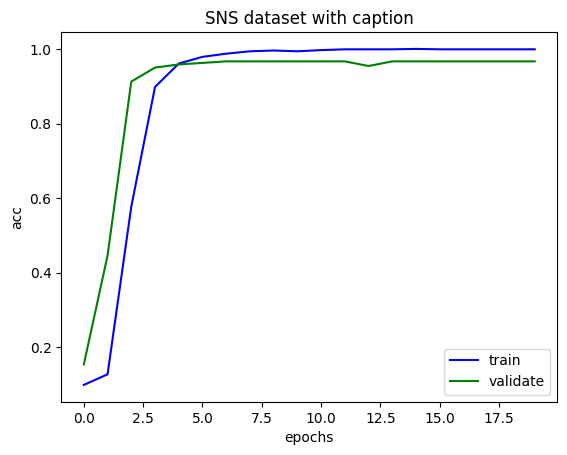

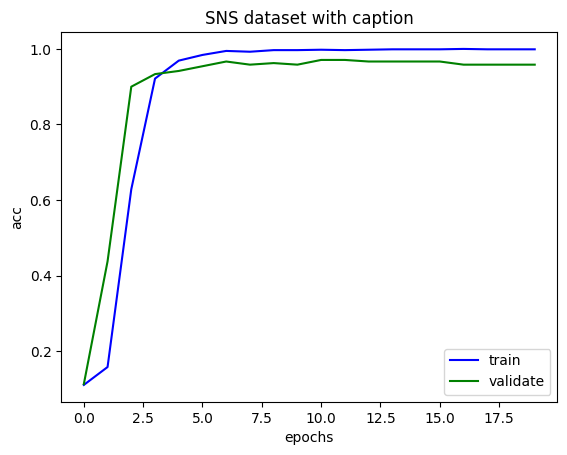

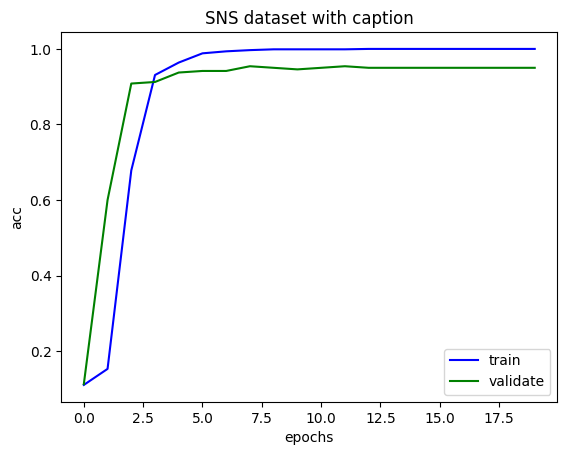

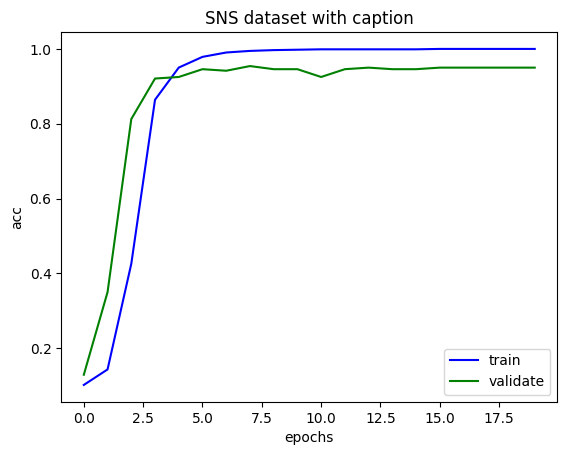

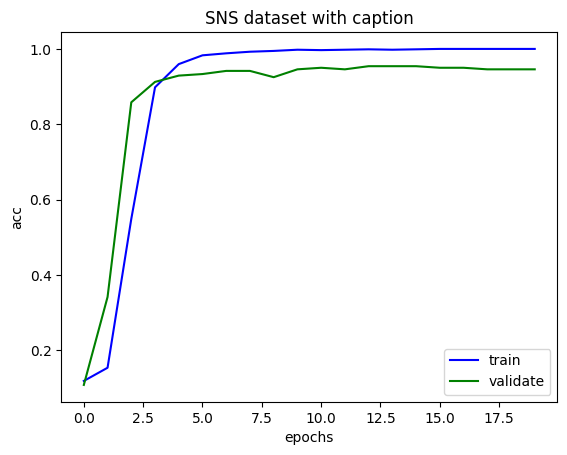

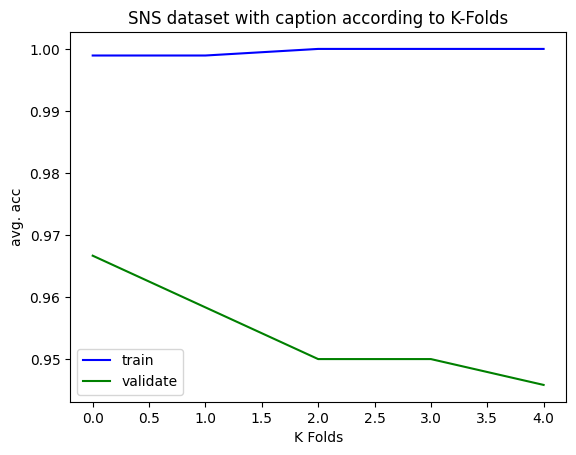

In [6]:
# groups = np.array([random.randint(0,6) for i in range(0,600)])
# gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
skf = StratifiedKFold(n_splits=n_splits)
#StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
nsplit =0
oldaccu = 0.0
trainarray = []
testarray =[]
# for trainidx, testidx in gss.split(np_data, np_label, groups=groups):
for trainidx,testidx in skf.split(np_data,np_label):
  # print("TRAIN:", trainidx, "TEST:", testidx)
  x_train,x_test,y_train,y_test = np_data[trainidx],np_data[testidx],np_label[trainidx],np_label[testidx]
  # print(x_train)
  # print(x_test)
  # print("%s %s" % (trainidx,testidx))
  data_train = BERTDataset(x_train, 1, 0, tok, max_len, True, False)
#   print("trainidx: ", len(trainidx))
#   print("x_train: ", len(x_train))
#   print("data_train: ", len(data_train))
  data_test = BERTDataset(x_test, 1, 0, tok, max_len, True, False)
  train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers) # before the num_workers = 5
  test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)  
  # load the initial model parameters
  checkpoint = torch.load('kobert.pt')
  model.load_state_dict(checkpoint['modelA'])
  optimizer.load_state_dict(checkpoint['optimizerA'])
  model.to(device)

  t_total = len(train_dataloader) * num_epochs
  warmup_step = int(t_total * warmup_ratio)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
  trainacclist =[]
  testacclist =[]
  # model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
  # optimizer.step()
  # print("train_dataloader: ", len(train_dataloader))
 
  for e in range(num_epochs):
      train_acc = 0.0
      test_acc = 0.0
      model.train()
      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
          optimizer.zero_grad()
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)
          out = model(token_ids, valid_length, segment_ids)
          loss = loss_fn(out, label)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()
          scheduler.step()  # Update learning rate schedule
          train_acc += calc_accuracy(out, label)
          if batch_id % log_interval == 0:
              # print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
              print('Epoch {}/{} Batch {}/{} Cost: {:.6f} Train Acc {}'.format(e+1, num_epochs, batch_id+1, len(train_dataloader), loss.item(), train_acc / (batch_id+1)))
#       print("batch id: ", batch_id)
#       print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
      print('\nEpoch {}/{} Cost: {:.6f} Train Acc {}'.format(e+1, num_epochs, loss.item(), train_acc / len(train_dataloader)))
      trainacclist.append(train_acc / (batch_id+1))
      model.eval()
      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)
          out = model(token_ids, valid_length, segment_ids)
          test_acc += calc_accuracy(out, label)
      # print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
      print('\nEpoch {}/{} Cost: {:.6f} Test Acc {}'.format(e+1, num_epochs, loss.item(), test_acc / len(test_dataloader)))
      testacclist.append(test_acc / (batch_id+1))
      newaccu = test_acc / (batch_id+1)
      if newaccu > oldaccu:
        oldaccu = newaccu
        torch.save(model, model_name)
      gc.collect()  
  plt.figure()
  print(trainacclist)
  trainarray.append(trainacclist[-1])
  print(testacclist)
  testarray.append(testacclist[-1])
  x = np.arange(len(trainacclist))
  plt.plot(x,trainacclist,'b',label='train')
  plt.plot(x,testacclist,'g',label='validate')
  # plt.axis('equal')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.title('SNS dataset with caption')
  # plt.setp(lines, color='r', linewidth=2.0)
  plt.legend()
  plt.savefig('{}.png'.format(nsplit),format='png')
  nsplit +=1

plt.figure()
x = np.arange(len(trainarray))
plt.plot(x,trainarray,'b',label='train')
plt.plot(x,testarray,'g',label='validate')
# plt.axis('equal')
plt.xlabel('K Folds')
plt.ylabel('avg. acc')
plt.title('SNS dataset with caption according to K-Folds')
# plt.setp(lines, color='r', linewidth=2.0)
plt.legend()
plt.savefig('{}.png'.format(nsplit),format='png')
nsplit +=1

print(np.array(trainarray))
print(np.array(testarray))

# pd.DataFrame(np.array(trainarray)).to_csv('trainaccu.csv')
# pd.DataFrame(np.array(testarray)).to_csv('testaccu.csv')

In [7]:
def precision_at_K (X,Y,K, np_testdata):
  max_vals1,max_indicesK = torch.topk(X,K)
  # print(max_indicesK)
  precisionnum = 0
  index = 0
  for yi, maxindicesi in zip(Y,max_indicesK):
    precisionnum += yi in maxindicesi
    if yi != maxindicesi:
        print("")
        print(yi, maxindicesi)
        print(np_testdata[index])
        print("")
    index += 1
  
  #maxlength = max_indicesK.size()[0] #precision_acc
  return precisionnum

In [8]:
data_test = BERTDataset(np_testdata, 1, 0, tok, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=num_workers) 
gc.collect()
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# tensor = torch.ones(())
# wholelabel =tensor.new_empty()
# wholeout =tensor.new_empty()
wholelabel =[]
wholeout =[]
categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
modelbest = torch.load(model_name)
modelbest.to(device)
modelbest.eval()
precision_at_3 =0.0
test_acc1 =0.0
start = 0
end = start + batch_size
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = modelbest(token_ids, valid_length, segment_ids)
        labellist = [categorylist[labeli] for labeli in label]
        outlist = [categorylist[outi.argmax()] for outi in out]
        wholelabel+=labellist
        wholeout+=outlist
        test_acc1 += calc_accuracy(out, label)
        precision_at_3 += precision_at_K (out,label,1, np_testdata[start:end])
        start += batch_size
        end = start + batch_size

# print(test_acc1*(batch_id+1)/len(data_test))
print(precision_at_3)
# print(totallength)
print((len(data_test)))
print("Total Acc", precision_at_3/len(data_test))
confusion_matrix(wholelabel, wholeout,labels= categorylist)
np.save('confusionmatrix',confusion_matrix(wholelabel, wholeout,labels= categorylist))
confusion_matrix(wholelabel, wholeout,labels= categorylist)
print(confusion_matrix(wholelabel, wholeout,labels= categorylist))

print("accuracy:", accuracy_score(wholelabel, wholeout))
print("precision:", precision_score(wholelabel, wholeout,average = 'macro'))
print("Recall:", recall_score(wholelabel,wholeout,average='macro'))
print("F1_score:", f1_score(wholelabel,wholeout,average='macro'))


  0%|          | 0/50 [00:00<?, ?it/s]


tensor(1, device='cuda:4') tensor([2], device='cuda:4')
[1
 '햇살이 넘 좋았던날 햇살맛집 셀기꾼 찰칵찰칵 셀카를 찍어봅세 청순청순 여리여리 찍는것도 넘이쁘댜 청자켓 원피스 봄코디 카페스타그램 벚꽃 분']


tensor(2, device='cuda:4') tensor([3], device='cuda:4')
[2
 '송리단길 서울리즘 카페 관광객 모드로 찰칵 미세먼지 없는 밤 야외카페 찾다가 우연히 생각나서 찾아가 보았지롱 송리단길 석촌호수카페 야경 루푸탑 데이트그램 신난다그램 롯데월드타워 생일축하해요']


tensor(2, device='cuda:4') tensor([3], device='cuda:4')
[2 '한옥마을 전망 아름답다 인 잔 은평한옥마을 은평구카페 한옥카페 루프탑 한옥마을']


tensor(2, device='cuda:4') tensor([8], device='cuda:4')
[2
 '페이스 편하게 문의주세요 카톡 다 챙겨드려요 페이스 페이스클럽 클럽페이스 강남페이스 신논현페이스 페이스테이블 주말스타그램 클럽페이스테이블 클럽페이스무료입장 클럽플렉스 알콜그램 클럽배추 맞팔디엠 환영해요 클럽그램 클럽페이스예약 클럽스타그램 페이스예약 클럽레이스 클럽페이스게스트 해요 클럽무인 클럽 페이스게스트 클럽텐션 술스타그램 강남클럽페이스 클럽로컬']


tensor(4, device='cuda:4') tensor([2], device='cuda:4')
[4
 '하루의 시작은 항상 올리브나무 물주며 커피 한 잔 햇살이 좋아질수록 새순도 잎도 금새 자라나서 키우는 재미가 있어요 꽃도 피고 열매도 맺는다 길래 이번 여름 아주 기대중 올리브따서와인이랑 분양하려다차마못보내고키우는중 무럭무럭 자라다오 식물 나무스타그램 작업실']


tensor(4, device='cuda:4') tensor([2], device='cuda:4')
[4
 '하루의 시작은 항상 올리브나무 물주며 커피 한 잔 햇살이 좋아질수록 새순도 잎도 